In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [241]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [242]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = 3.0#2
std_dev = 2.0
total_samples = 10000#50000

train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 32#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 7000
Validation set size: 1500
Test set size: 1500


In [243]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    loss_2 = torch.sum(torch.log(torch.abs(det_jacobian) + 1e-10))
    # loss_2 = torch.sum(torch.log(det_jacobian + 1e-10))
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-alpha_nll*loss_2)/ dataset_length
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1/dataset_length, loss_2/dataset_length
    return loss_with_alpha, loss_normal

In [244]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.7, 
                density=True, label=labels_list[i])
        plt.legend()

In [245]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, "-o",label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)  # Optional: Add a grid

In [246]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [247]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()#loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2 += loss_2.item()# initially this + was missing
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2 * int(tv2_regulation)}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [248]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [249]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [250]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [251]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.

    Returns:
    None
    """
    num_epochs = len(models_params)
    num_rows = int(np.ceil(np.sqrt(num_epochs)))
    num_cols = int(np.ceil(num_epochs / num_rows))
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for i, ax in enumerate(axes):
        if i < num_epochs:

            #
            if print_model_params:
                print(models_params[i])
            # Load model weights for the current epoch
            load_weights_into_model(model, models_params[i])
            
            # Encode the test data
            with torch.no_grad():
                encoded_test1 = model(test_tensor)
            
            # Plot histogram on the subplot
            ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
            ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
            
            # Set title
            if i == 0:
                ax.set_title("Before Training")
            else:
                ax.set_title(f"Epoch {i}")  # Start epoch count from 1
            ax.set_xlabel("Values")
            ax.set_ylabel("Density")
            ax.grid(True)
        else:
            # Hide unused subplots
            ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


In [252]:
def generate_unequally_spaced_sorted_numbers(start_val, end_val, N):
    """
    Generate N unequally spaced but sorted numbers between start_val and end_val.

    Parameters:
        start_val (float): The starting value of the range.
        end_val (float): The ending value of the range.
        N (int): Number of numbers to generate.

    Returns:
        torch.Tensor: A tensor of N sorted, unequally spaced numbers.
    """
    assert N > 1, "N must be greater than 1 to create a range."
    assert start_val < end_val, "start_val must be less than end_val."
    
    # Generate N random values between 0 and 1
    random_values = torch.rand(N)
    
    # Sort the random values to ensure monotonicity
    sorted_values = torch.sort(random_values).values
    
    # Scale and shift the values to fit into the range [start_val, end_val]
    scaled_values = start_val + (end_val - start_val) * sorted_values
    
    return scaled_values


initial nodal_val_locs: tensor([[-10.7631,  -9.8174,  -9.6253,  -8.8662,  -3.9813,  -3.9771,  -2.7391,
          -2.0906,  -1.5254,  -1.0559,  -0.5623,   0.8543,   1.2473,   1.4213,
           2.0124,   4.5421,   7.6015,   7.7439,   8.7773,   8.8362,   9.1561]])
initial fn values: Parameter containing:
tensor([-9.8148, -8.7912, -8.8596, -8.0443, -3.8297, -3.4611, -1.9471, -1.5882,
        -1.5143, -0.4768,  0.2322,  1.3884,  2.2587,  1.6801,  2.1427,  5.6401,
         7.7800,  8.8067,  9.6971,  9.2731,  9.8693], requires_grad=True)
constrained coefficients are:  tensor([-9.7544e+00, -8.7309e+00, -8.7290e+00, -7.9137e+00, -3.6990e+00,
        -3.6865e+00, -2.1725e+00, -1.8136e+00, -1.7397e+00, -7.0214e-01,
         6.8166e-03,  1.1630e+00,  2.0333e+00,  2.0350e+00,  2.4977e+00,
         5.9951e+00,  8.1349e+00,  8.5621e+00,  9.4524e+00,  9.4530e+00,
         1.0049e+01], grad_fn=<ViewBackward0>)
slopes: constrained coeffs: tensor([[1.0824, 1.0824, 0.0100, 1.0740, 0.8628, 3.0000, 1.2230,

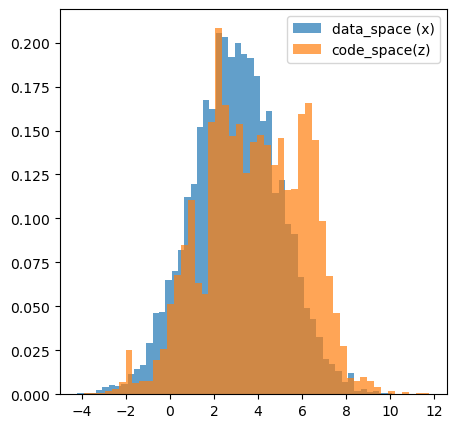

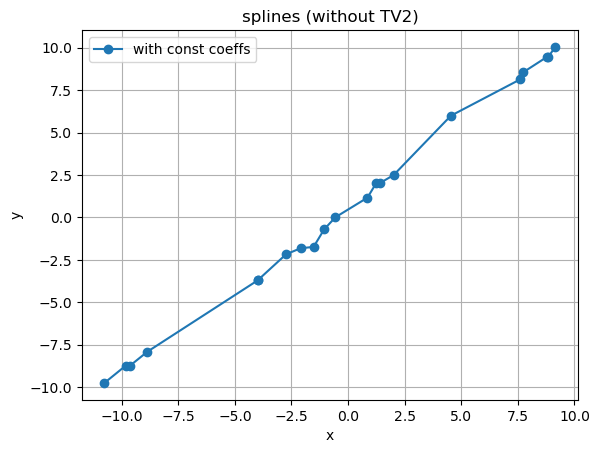

In [253]:
SIZE=21;RANGE=11; START_VAL=-6; END_VAL=11
GRID_VALS= generate_unequally_spaced_sorted_numbers(start_val=START_VAL,end_val=END_VAL,N=SIZE)
model2 = LinearSplineSlopeConstrained(
                mode='fc',
                num_activations=1,
                size=SIZE,# number of knots is size -2
                range_=RANGE,
                #grid_values=GRID_VALS,
                # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                init="random",#"maxmin",# what if I try relu activation function?
                smin=0.01,
                smax=3,
                slope_constrained=1
) # slopes of splines is 1, obviously

print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["data_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0)
plt.legend()
plt.show()

In [260]:
# training # from what we understand, this thing is strictly dependent 
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=40, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.005, # 
    print_after=1, #
    track_coefficients=1, # so yes, it indeed leads to something, however it is also quite dependent on the form of initialisation
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.05, #
    gamma = 0.5, # 
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) # why is it no # good thing is that it is shifting but the bad thing is that its kind of collapsing to 0

Training Progress:   2%|▎         | 1/40 [00:05<03:25,  5.28s/it]

Epoch 1/40,  train NLL+0.05XTV2: 1.488218998255795, data avg loss-1: 0.5767859147700001 ,data avg loss-2: -0.6242338957851881 ,Training NLL Loss: 1.2010198121201503, Validation NLL Loss: 1.1680074080507805, LR: 0.005


Training Progress:   5%|▌         | 2/40 [00:11<03:34,  5.65s/it]

Epoch 2/40,  train NLL+0.05XTV2: 1.4877994022412933, data avg loss-1: 0.571750614400868 ,data avg loss-2: -0.6299942759074033 ,Training NLL Loss: 1.2017448939144884, Validation NLL Loss: 1.1683213901012501, LR: 0.005


Training Progress:   8%|▊         | 3/40 [00:17<03:38,  5.91s/it]

Epoch 3/40,  train NLL+0.05XTV2: 1.4838839165151936, data avg loss-1: 0.5513656177477205 ,data avg loss-2: -0.6447276059351011 ,Training NLL Loss: 1.1960932255879928, Validation NLL Loss: 1.1600699792516993, LR: 0.005


Training Progress:  10%|█         | 4/40 [00:22<03:17,  5.48s/it]

Epoch 4/40,  train NLL+0.05XTV2: 1.4816161154612015, data avg loss-1: 0.5475081873538832 ,data avg loss-2: -0.6470857284384776 ,Training NLL Loss: 1.1945939159284444, Validation NLL Loss: 1.160578579344648, LR: 0.005


Training Progress:  12%|█▎        | 5/40 [00:27<03:03,  5.25s/it]

Epoch 5/40,  train NLL+0.05XTV2: 1.4806635864249102, data avg loss-1: 0.5401069954650043 ,data avg loss-2: -0.654481453710495 ,Training NLL Loss: 1.1945884459094913, Validation NLL Loss: 1.1596733420453174, LR: 0.005


Training Progress:  15%|█▌        | 6/40 [00:31<02:51,  5.04s/it]

Epoch 6/40,  train NLL+0.05XTV2: 1.4830723244305615, data avg loss-1: 0.5393302629799603 ,data avg loss-2: -0.6581780760799913 ,Training NLL Loss: 1.1975083378351987, Validation NLL Loss: 1.1637586583482458, LR: 0.005


Training Progress:  18%|█▊        | 7/40 [00:36<02:45,  5.00s/it]

Epoch 7/40,  train NLL+0.05XTV2: 1.478665602805952, data avg loss-1: 0.5198024437852102 ,data avg loss-2: -0.6734805006414788 ,Training NLL Loss: 1.1932829446988562, Validation NLL Loss: 1.1580210860739364, LR: 0.005


Training Progress:  20%|██        | 8/40 [00:41<02:39,  4.97s/it]

Epoch 8/40,  train NLL+0.05XTV2: 1.4782135013031632, data avg loss-1: 0.5132604985068377 ,data avg loss-2: -0.6795741439409996 ,Training NLL Loss: 1.1928346445571343, Validation NLL Loss: 1.1587677724817966, LR: 0.005


Training Progress:  22%|██▎       | 9/40 [00:46<02:38,  5.11s/it]

Epoch 9/40,  train NLL+0.05XTV2: 1.478407847282549, data avg loss-1: 0.5109081765696338 ,data avg loss-2: -0.6824550666765535 ,Training NLL Loss: 1.1933632395038867, Validation NLL Loss: 1.1643120811340657, LR: 0.005


Training Progress:  25%|██▌       | 10/40 [00:52<02:38,  5.27s/it]

Epoch 10/40,  train NLL+0.05XTV2: 1.4777225092665789, data avg loss-1: 0.5027548644912841 ,data avg loss-2: -0.6905914849886611 ,Training NLL Loss: 1.1933463501603636, Validation NLL Loss: 1.161171686142049, LR: 0.005


Training Progress:  28%|██▊       | 11/40 [00:57<02:28,  5.11s/it]

Epoch 11/40,  train NLL+0.05XTV2: 1.4772314905575965, data avg loss-1: 0.49516563239979416 ,data avg loss-2: -0.6974769936848993 ,Training NLL Loss: 1.1926426212537233, Validation NLL Loss: 1.1603858737235373, LR: 0.005


Training Progress:  30%|███       | 12/40 [01:02<02:22,  5.08s/it]

Epoch 12/40,  train NLL+0.05XTV2: 1.4786569125031772, data avg loss-1: 0.48857971644837017 ,data avg loss-2: -0.7049918452354327 ,Training NLL Loss: 1.1935715610033846, Validation NLL Loss: 1.1601804406084912, LR: 0.005


Training Progress:  32%|███▎      | 13/40 [01:07<02:13,  4.95s/it]

Epoch 13/40,  train NLL+0.05XTV2: 1.4775648247705746, data avg loss-1: 0.4853715677511746 ,data avg loss-2: -0.70814519685153 ,Training NLL Loss: 1.1935167601119439, Validation NLL Loss: 1.1615182706650267, LR: 0.005


Training Progress:  35%|███▌      | 14/40 [01:11<02:08,  4.95s/it]

Epoch 14/40,  train NLL+0.05XTV2: 1.4793992233058633, data avg loss-1: 0.48338953653971356 ,data avg loss-2: -0.7129865139042406 ,Training NLL Loss: 1.1963760463614441, Validation NLL Loss: 1.1707918314223593, LR: 0.0025


Training Progress:  38%|███▊      | 15/40 [01:16<02:01,  4.85s/it]

Epoch 15/40,  train NLL+0.05XTV2: 1.4792108786160543, data avg loss-1: 0.47584168238726926 ,data avg loss-2: -0.7214499023407017 ,Training NLL Loss: 1.1972915845918872, Validation NLL Loss: 1.1679225728866902, LR: 0.0025


Training Progress:  40%|████      | 16/40 [01:21<01:55,  4.83s/it]

Epoch 16/40,  train NLL+0.05XTV2: 1.4774846116157427, data avg loss-1: 0.47047691380596596 ,data avg loss-2: -0.7249367710662215 ,Training NLL Loss: 1.1954136825587651, Validation NLL Loss: 1.1670835842477514, LR: 0.0025


Training Progress:  42%|████▎     | 17/40 [01:26<01:50,  4.81s/it]

Epoch 17/40,  train NLL+0.05XTV2: 1.477592287542613, data avg loss-1: 0.4670743129841269 ,data avg loss-2: -0.7284586914053791 ,Training NLL Loss: 1.1955330050699242, Validation NLL Loss: 1.167752060484379, LR: 0.00125


Training Progress:  45%|████▌     | 18/40 [01:30<01:45,  4.80s/it]

Epoch 18/40,  train NLL+0.05XTV2: 1.477027619810409, data avg loss-1: 0.4651263070433107 ,data avg loss-2: -0.7303047819769002 ,Training NLL Loss: 1.1954310917418842, Validation NLL Loss: 1.1674463444567742, LR: 0.00125


Training Progress:  48%|████▊     | 19/40 [01:35<01:41,  4.83s/it]

Epoch 19/40,  train NLL+0.05XTV2: 1.4773845776031007, data avg loss-1: 0.4642628036677565 ,data avg loss-2: -0.7316854397455851 ,Training NLL Loss: 1.1959482406916684, Validation NLL Loss: 1.168577638078243, LR: 0.00125


Training Progress:  50%|█████     | 20/40 [01:40<01:38,  4.90s/it]

Epoch 20/40,  train NLL+0.05XTV2: 1.4784738963053106, data avg loss-1: 0.46389138596515134 ,data avg loss-2: -0.7333217255056721 ,Training NLL Loss: 1.197213106775937, Validation NLL Loss: 1.1693327300092007, LR: 0.000625


Training Progress:  52%|█████▎    | 21/40 [01:45<01:32,  4.86s/it]

Epoch 21/40,  train NLL+0.05XTV2: 1.4784571389629417, data avg loss-1: 0.46092193624744676 ,data avg loss-2: -0.7363957210218526 ,Training NLL Loss: 1.1973176544115423, Validation NLL Loss: 1.1681907963245473, LR: 0.000625


Training Progress:  55%|█████▌    | 22/40 [01:50<01:27,  4.88s/it]

Epoch 22/40,  train NLL+0.05XTV2: 1.477379968177238, data avg loss-1: 0.4578284675672174 ,data avg loss-2: -0.7383527701303839 ,Training NLL Loss: 1.196181232526422, Validation NLL Loss: 1.1672838774133236, LR: 0.000625


Training Progress:  57%|█████▊    | 23/40 [01:55<01:22,  4.84s/it]

Epoch 23/40,  train NLL+0.05XTV2: 1.4771974832499952, data avg loss-1: 0.45620343306837563 ,data avg loss-2: -0.7398160472852454 ,Training NLL Loss: 1.1960194818505414, Validation NLL Loss: 1.1667855267829084, LR: 0.0003125


Training Progress:  60%|██████    | 24/40 [01:59<01:16,  4.77s/it]

Epoch 24/40,  train NLL+0.05XTV2: 1.4771284871994088, data avg loss-1: 0.4553776256161738 ,data avg loss-2: -0.7406462684069595 ,Training NLL Loss: 1.1960238882395775, Validation NLL Loss: 1.167508732765279, LR: 0.0003125


Training Progress:  62%|██████▎   | 25/40 [02:04<01:11,  4.77s/it]

Epoch 25/40,  train NLL+0.05XTV2: 1.4771887586541372, data avg loss-1: 0.45522129141032425 ,data avg loss-2: -0.7409218590553492 ,Training NLL Loss: 1.1961431467914145, Validation NLL Loss: 1.1679366180237303, LR: 0.0003125


Training Progress:  65%|██████▌   | 26/40 [02:09<01:07,  4.84s/it]

Epoch 26/40,  train NLL+0.05XTV2: 1.4774931625688457, data avg loss-1: 0.4544406777511449 ,data avg loss-2: -0.7420275796493984 ,Training NLL Loss: 1.1964682585572544, Validation NLL Loss: 1.1678823803333527, LR: 0.00015625


Training Progress:  68%|██████▊   | 27/40 [02:15<01:05,  5.00s/it]

Epoch 27/40,  train NLL+0.05XTV2: 1.4773369167493358, data avg loss-1: 0.4533777363496284 ,data avg loss-2: -0.7429705390102788 ,Training NLL Loss: 1.1963482754959909, Validation NLL Loss: 1.1681373550536784, LR: 0.00015625


Training Progress:  70%|███████   | 28/40 [02:19<00:58,  4.88s/it]

Epoch 28/40,  train NLL+0.05XTV2: 1.4773548155614775, data avg loss-1: 0.4528230289209923 ,data avg loss-2: -0.7435775004565444 ,Training NLL Loss: 1.1964005338002557, Validation NLL Loss: 1.1684186547360522, LR: 0.00015625


Training Progress:  72%|███████▎  | 29/40 [02:24<00:53,  4.84s/it]

Epoch 29/40,  train NLL+0.05XTV2: 1.477542116761752, data avg loss-1: 0.4520931650106221 ,data avg loss-2: -0.7444940906137092 ,Training NLL Loss: 1.1965872536511182, Validation NLL Loss: 1.1682593480069587, LR: 7.8125e-05


Training Progress:  75%|███████▌  | 30/40 [02:29<00:49,  4.95s/it]

Epoch 30/40,  train NLL+0.05XTV2: 1.477360257819363, data avg loss-1: 0.45151782648204125 ,data avg loss-2: -0.7449070479227528 ,Training NLL Loss: 1.196424878079053, Validation NLL Loss: 1.1684779283848215, LR: 7.8125e-05


Training Progress:  78%|███████▊  | 31/40 [02:34<00:43,  4.85s/it]

Epoch 31/40,  train NLL+0.05XTV2: 1.477643248697394, data avg loss-1: 0.45147496026400563 ,data avg loss-2: -0.745237878468483 ,Training NLL Loss: 1.1967128351943133, Validation NLL Loss: 1.1684763773958733, LR: 7.8125e-05


Training Progress:  80%|████████  | 32/40 [02:39<00:39,  4.93s/it]

Epoch 32/40,  train NLL+0.05XTV2: 1.4774258784507508, data avg loss-1: 0.4510000793765125 ,data avg loss-2: -0.7455027481736658 ,Training NLL Loss: 1.1965028276182201, Validation NLL Loss: 1.1682874446219587, LR: 3.90625e-05


Training Progress:  82%|████████▎ | 33/40 [02:44<00:35,  5.06s/it]

Epoch 33/40,  train NLL+0.05XTV2: 1.4777270648033107, data avg loss-1: 0.4508235288537256 ,data avg loss-2: -0.7459656726824094 ,Training NLL Loss: 1.1967891963649557, Validation NLL Loss: 1.1681771506654455, LR: 3.90625e-05


Training Progress:  85%|████████▌ | 34/40 [02:49<00:29,  4.95s/it]

Epoch 34/40,  train NLL+0.05XTV2: 1.4775833479345661, data avg loss-1: 0.45054743258648267 ,data avg loss-2: -0.7461031283417793 ,Training NLL Loss: 1.1966505611323874, Validation NLL Loss: 1.1682414983181244, LR: 3.90625e-05


Training Progress:  88%|████████▊ | 35/40 [02:54<00:24,  4.90s/it]

Epoch 35/40,  train NLL+0.05XTV2: 1.4777903262883016, data avg loss-1: 0.4505649296116067 ,data avg loss-2: -0.7462960721150925 ,Training NLL Loss: 1.1968609960111853, Validation NLL Loss: 1.1682677433845845, LR: 1.953125e-05


Training Progress:  90%|█████████ | 36/40 [02:59<00:19,  4.88s/it]

Epoch 36/40,  train NLL+0.05XTV2: 1.4778888062255022, data avg loss-1: 0.45058646362666127 ,data avg loss-2: -0.7463783934780451 ,Training NLL Loss: 1.1969648640449733, Validation NLL Loss: 1.1682588115651558, LR: 1.953125e-05


Training Progress:  92%|█████████▎| 37/40 [03:03<00:14,  4.88s/it]

Epoch 37/40,  train NLL+0.05XTV2: 1.4776322389846523, data avg loss-1: 0.45022710572639013 ,data avg loss-2: -0.7464813598214763 ,Training NLL Loss: 1.1967084639148624, Validation NLL Loss: 1.168265776431307, LR: 1.953125e-05


Training Progress:  95%|█████████▌| 38/40 [03:09<00:09,  4.97s/it]

Epoch 38/40,  train NLL+0.05XTV2: 1.4775136916060425, data avg loss-1: 0.45009049017951913 ,data avg loss-2: -0.7465009000747715 ,Training NLL Loss: 1.1965913859676554, Validation NLL Loss: 1.1682700540157074, LR: 9.765625e-06


Training Progress:  98%|█████████▊| 39/40 [03:14<00:05,  5.06s/it]

Epoch 39/40,  train NLL+0.05XTV2: 1.4773638297433722, data avg loss-1: 0.449938842831137 ,data avg loss-2: -0.7465045691625168 ,Training NLL Loss: 1.1964434113132354, Validation NLL Loss: 1.168293742423362, LR: 9.765625e-06


Training Progress: 100%|██████████| 40/40 [03:19<00:00,  4.99s/it]

Epoch 40/40,  train NLL+0.05XTV2: 1.4775182651058179, data avg loss-1: 0.45004529039881547 ,data avg loss-2: -0.7465535209059171 ,Training NLL Loss: 1.1965988134140293, Validation NLL Loss: 1.1682802451417802, LR: 9.765625e-06
Training complete


In [161]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=20000,
                    print_model_params=0
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                            ],

                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y")
    plt.legend()
    plt.show()
    ## 
    print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    plot_coefficients_evolution(num_coeffs,
                                np.array(coeffs_unconstrained_evol2), 
                                np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) # slopes of splines is 1, obviously
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=(20,20), num_samples=num_samples,
                                print_model_params=print_model_params)


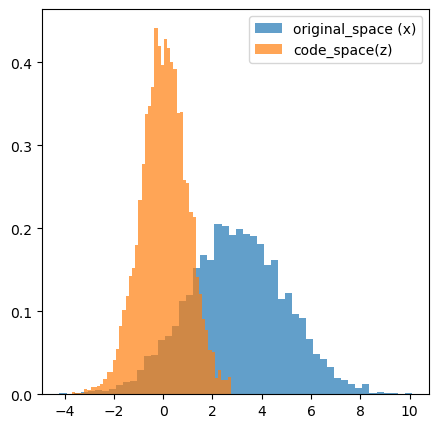

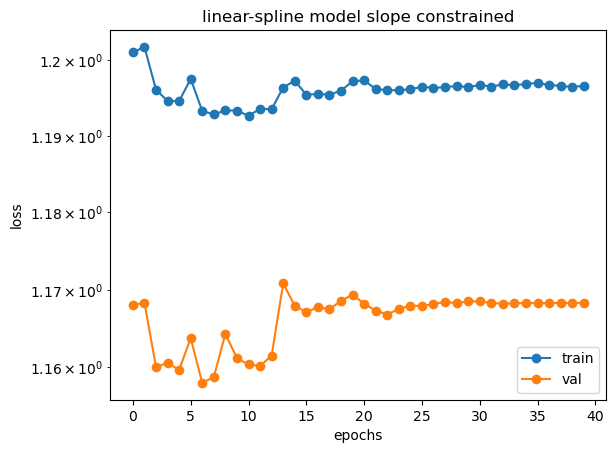

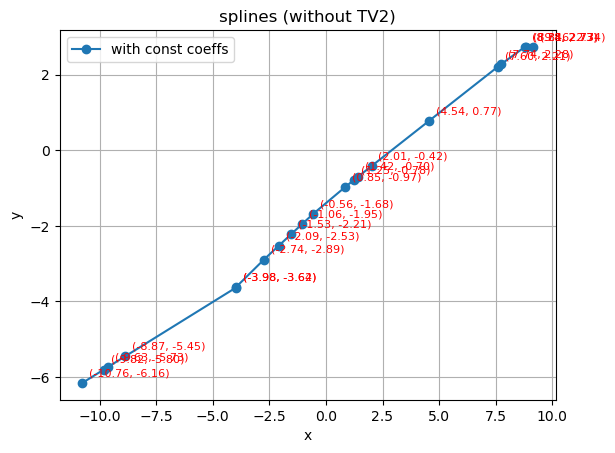

slopes: constrained coeffs: tensor([[0.3716, 0.3716, 0.3716, 0.3716, 0.3716, 3.0000, 0.5912, 0.5601, 0.5568,
         0.5539, 0.5505, 0.5032, 0.4813, 0.4735, 0.4714, 0.4711, 0.4711, 0.4698,
         0.4355, 0.0100, 0.0100]], grad_fn=<ClampBackward1>)


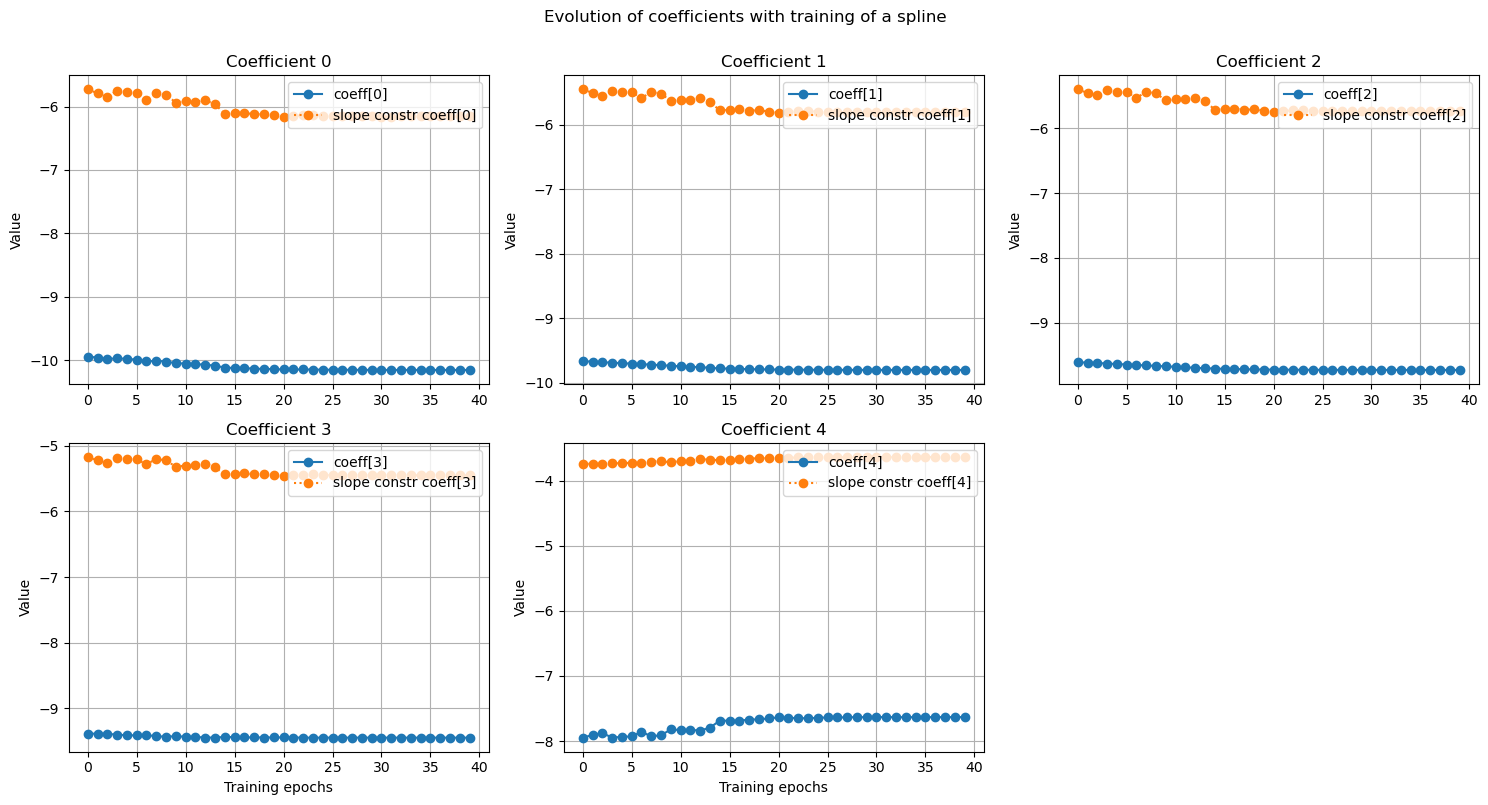

initial nodal_val_locs: tensor([[-10.7631,  -9.8174,  -9.6253,  -8.8662,  -3.9813,  -3.9771,  -2.7391,
          -2.0906,  -1.5254,  -1.0559,  -0.5623,   0.8543,   1.2473,   1.4213,
           2.0124,   4.5421,   7.6015,   7.7439,   8.7773,   8.8362,   9.1561]])
initial fn values: Parameter containing:
tensor([10.7631,  9.8174,  9.6253,  8.8662,  3.9813,  3.9771,  2.7391,  2.0906,
         1.5254,  1.0559,  0.5623,  0.8543,  1.2473,  1.4213,  2.0124,  4.5421,
         7.6015,  7.7439,  8.7773,  8.8362,  9.1561], requires_grad=True)


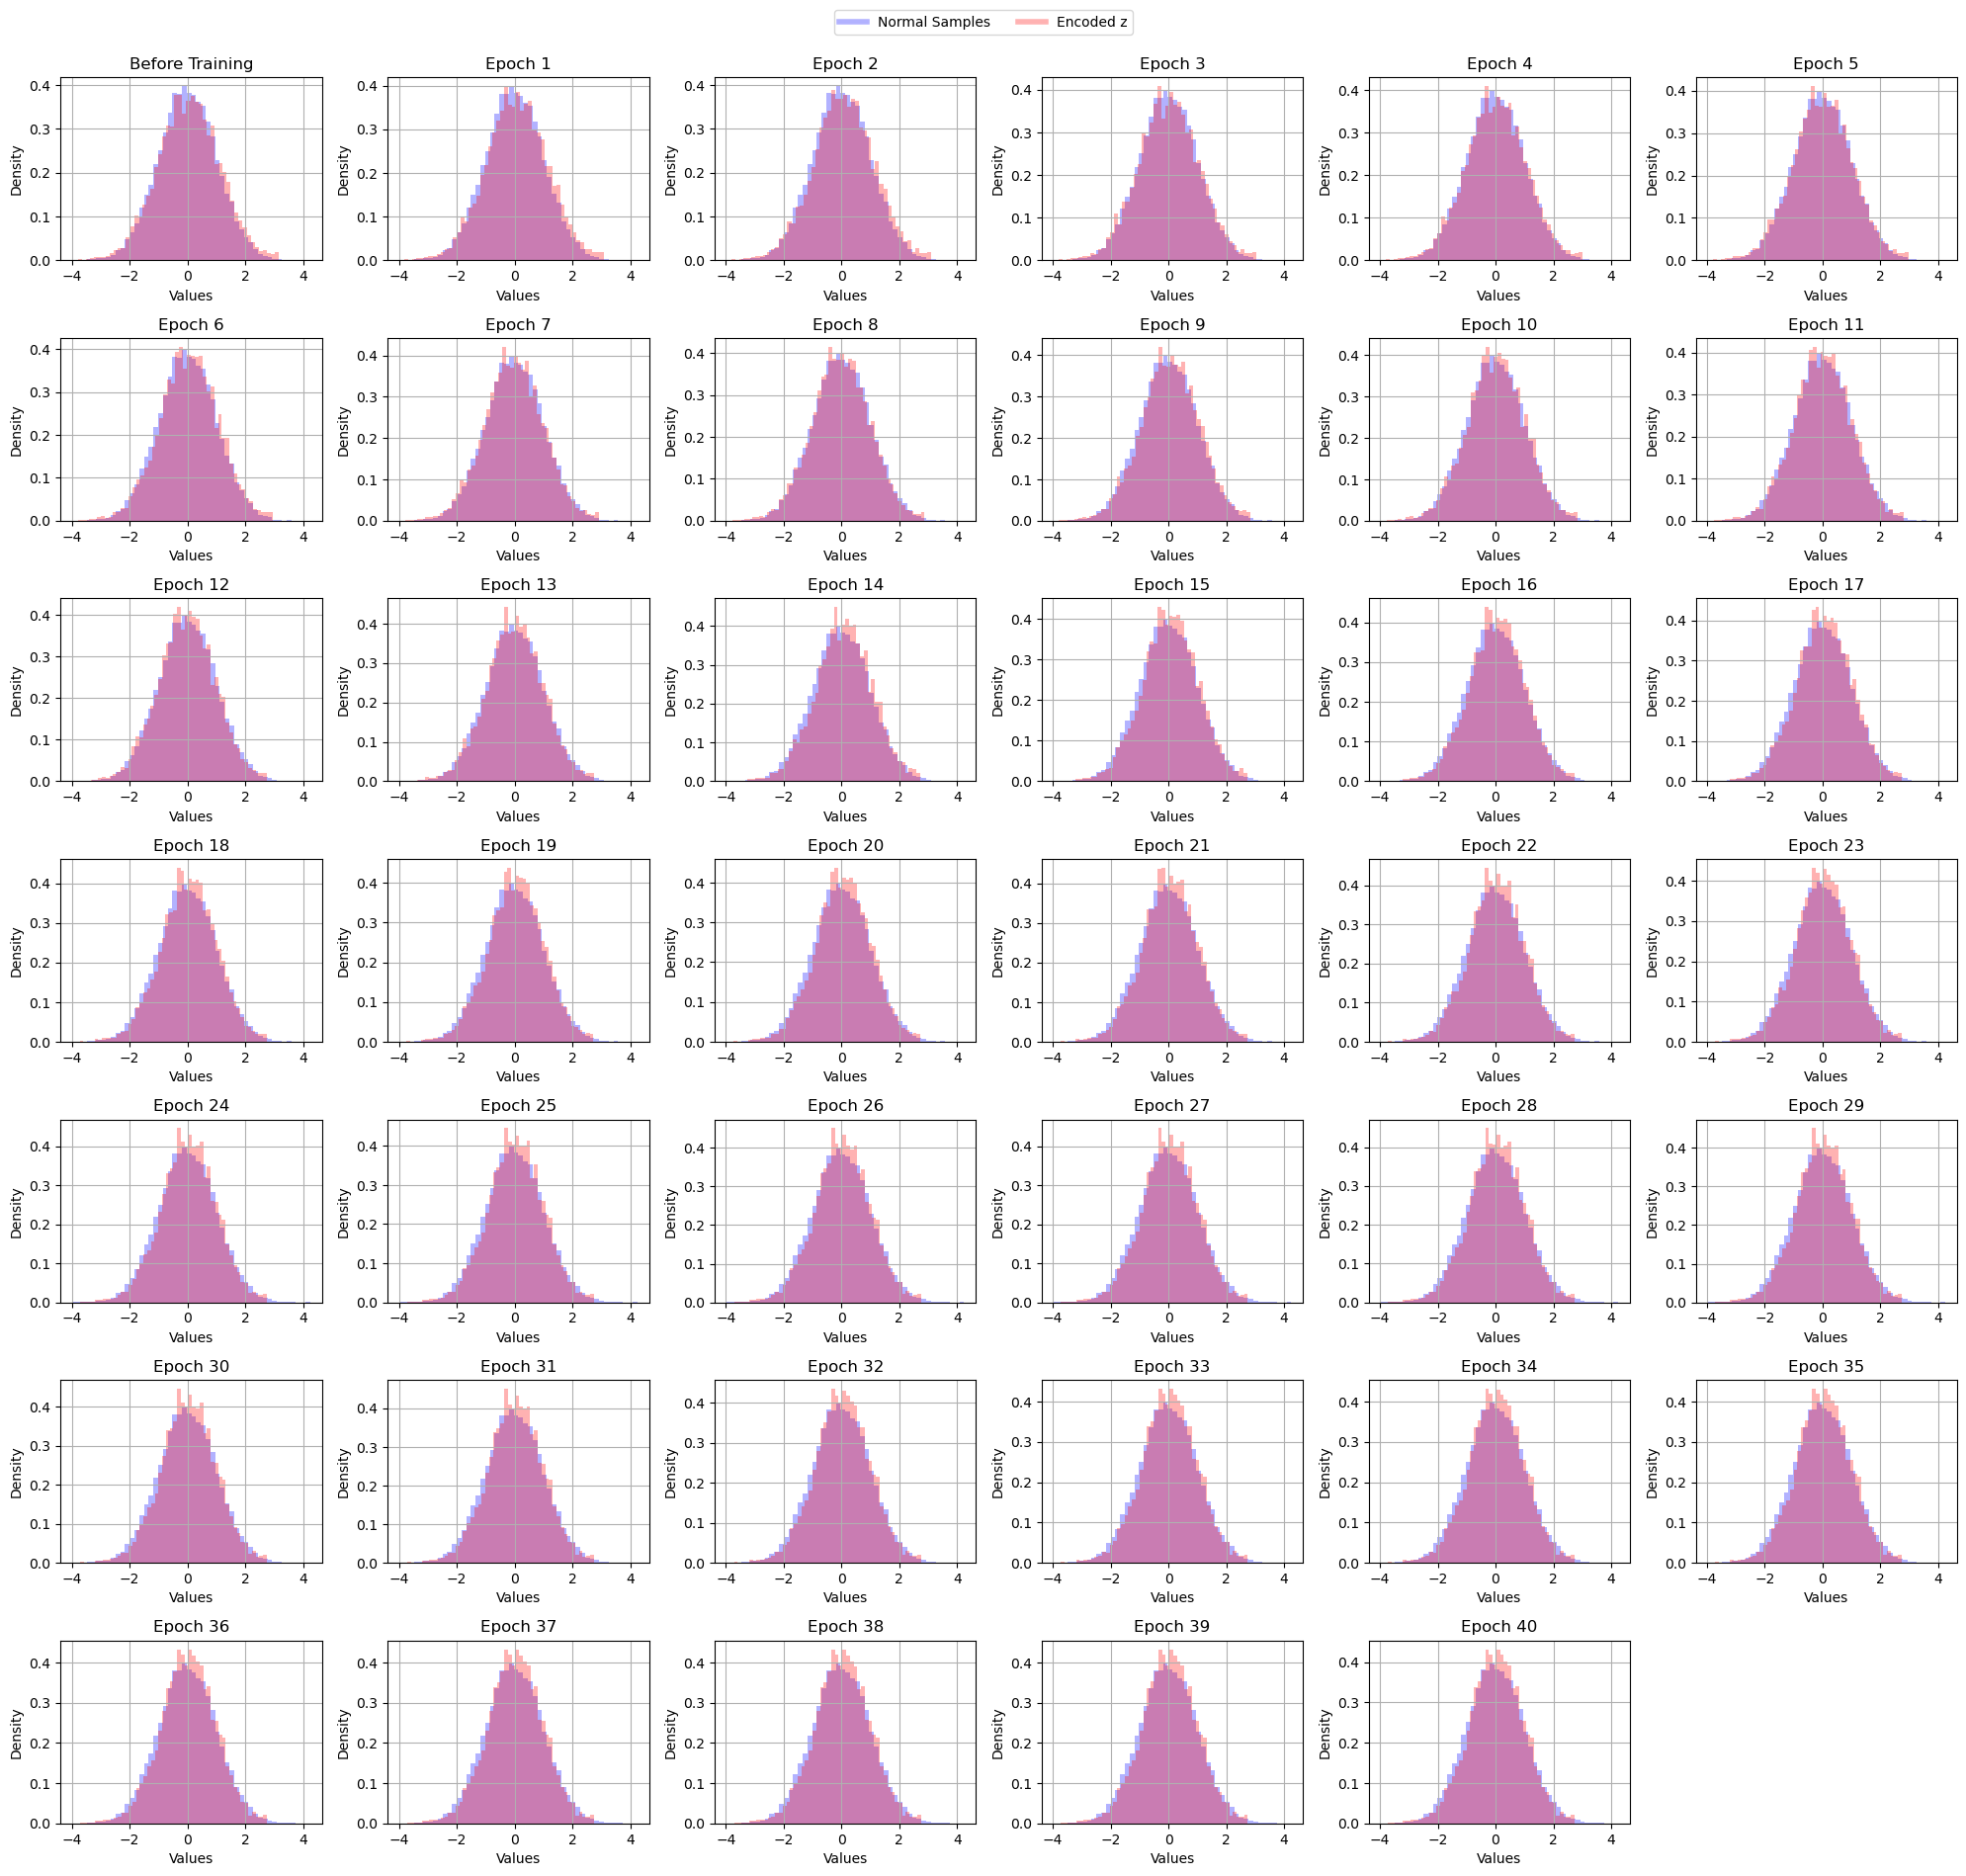

In [261]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data,
                model_params_list=epoch_wise_param_list,
                num_coeffs=5,print_model_params=0) # 40 more (30 below+40 x2 below + 40 here = 70+40+40=110+40=150)

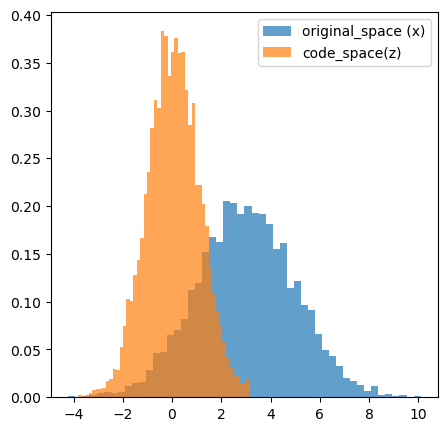

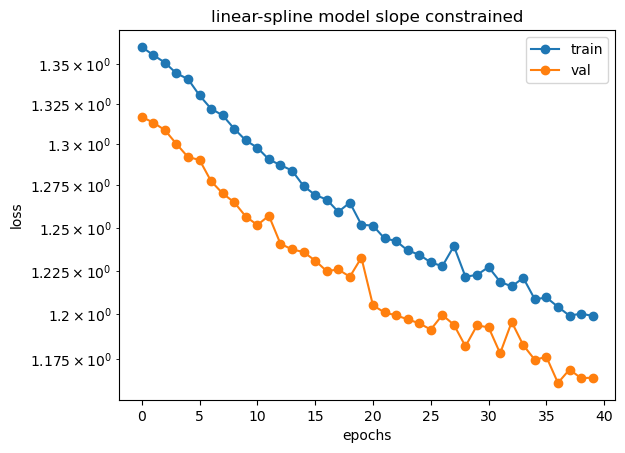

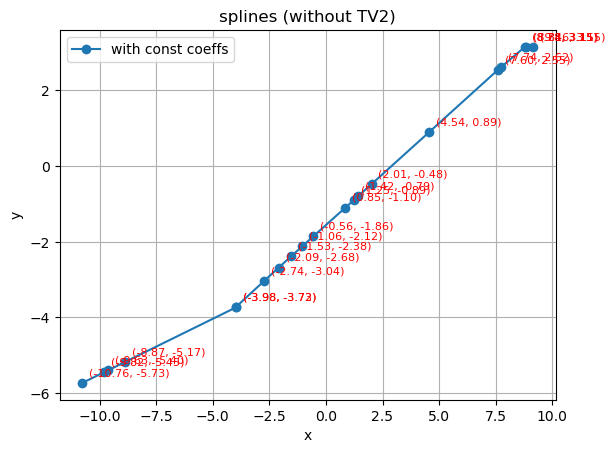

slopes: constrained coeffs: tensor([[0.2943, 0.2943, 0.2868, 0.2948, 0.2942, 3.0000, 0.5524, 0.5500, 0.5406,
         0.5405, 0.5369, 0.5367, 0.5317, 0.5464, 0.5382, 0.5400, 0.5416, 0.5215,
         0.5085, 0.0100, 0.0100]], grad_fn=<ClampBackward1>)


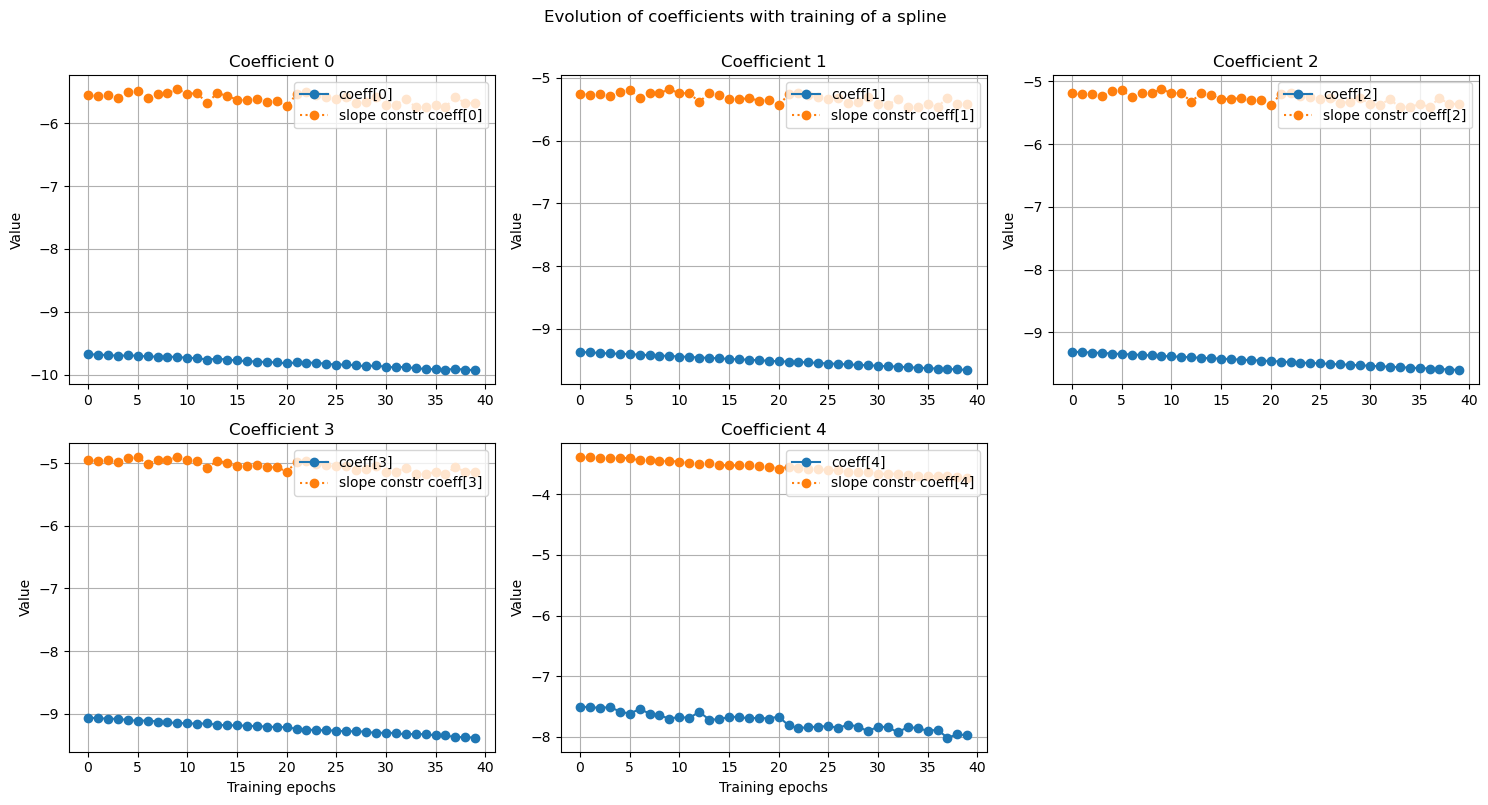

initial nodal_val_locs: tensor([[-10.7631,  -9.8174,  -9.6253,  -8.8662,  -3.9813,  -3.9771,  -2.7391,
          -2.0906,  -1.5254,  -1.0559,  -0.5623,   0.8543,   1.2473,   1.4213,
           2.0124,   4.5421,   7.6015,   7.7439,   8.7773,   8.8362,   9.1561]])
initial fn values: Parameter containing:
tensor([10.7631,  9.8174,  9.6253,  8.8662,  3.9813,  3.9771,  2.7391,  2.0906,
         1.5254,  1.0559,  0.5623,  0.8543,  1.2473,  1.4213,  2.0124,  4.5421,
         7.6015,  7.7439,  8.7773,  8.8362,  9.1561], requires_grad=True)


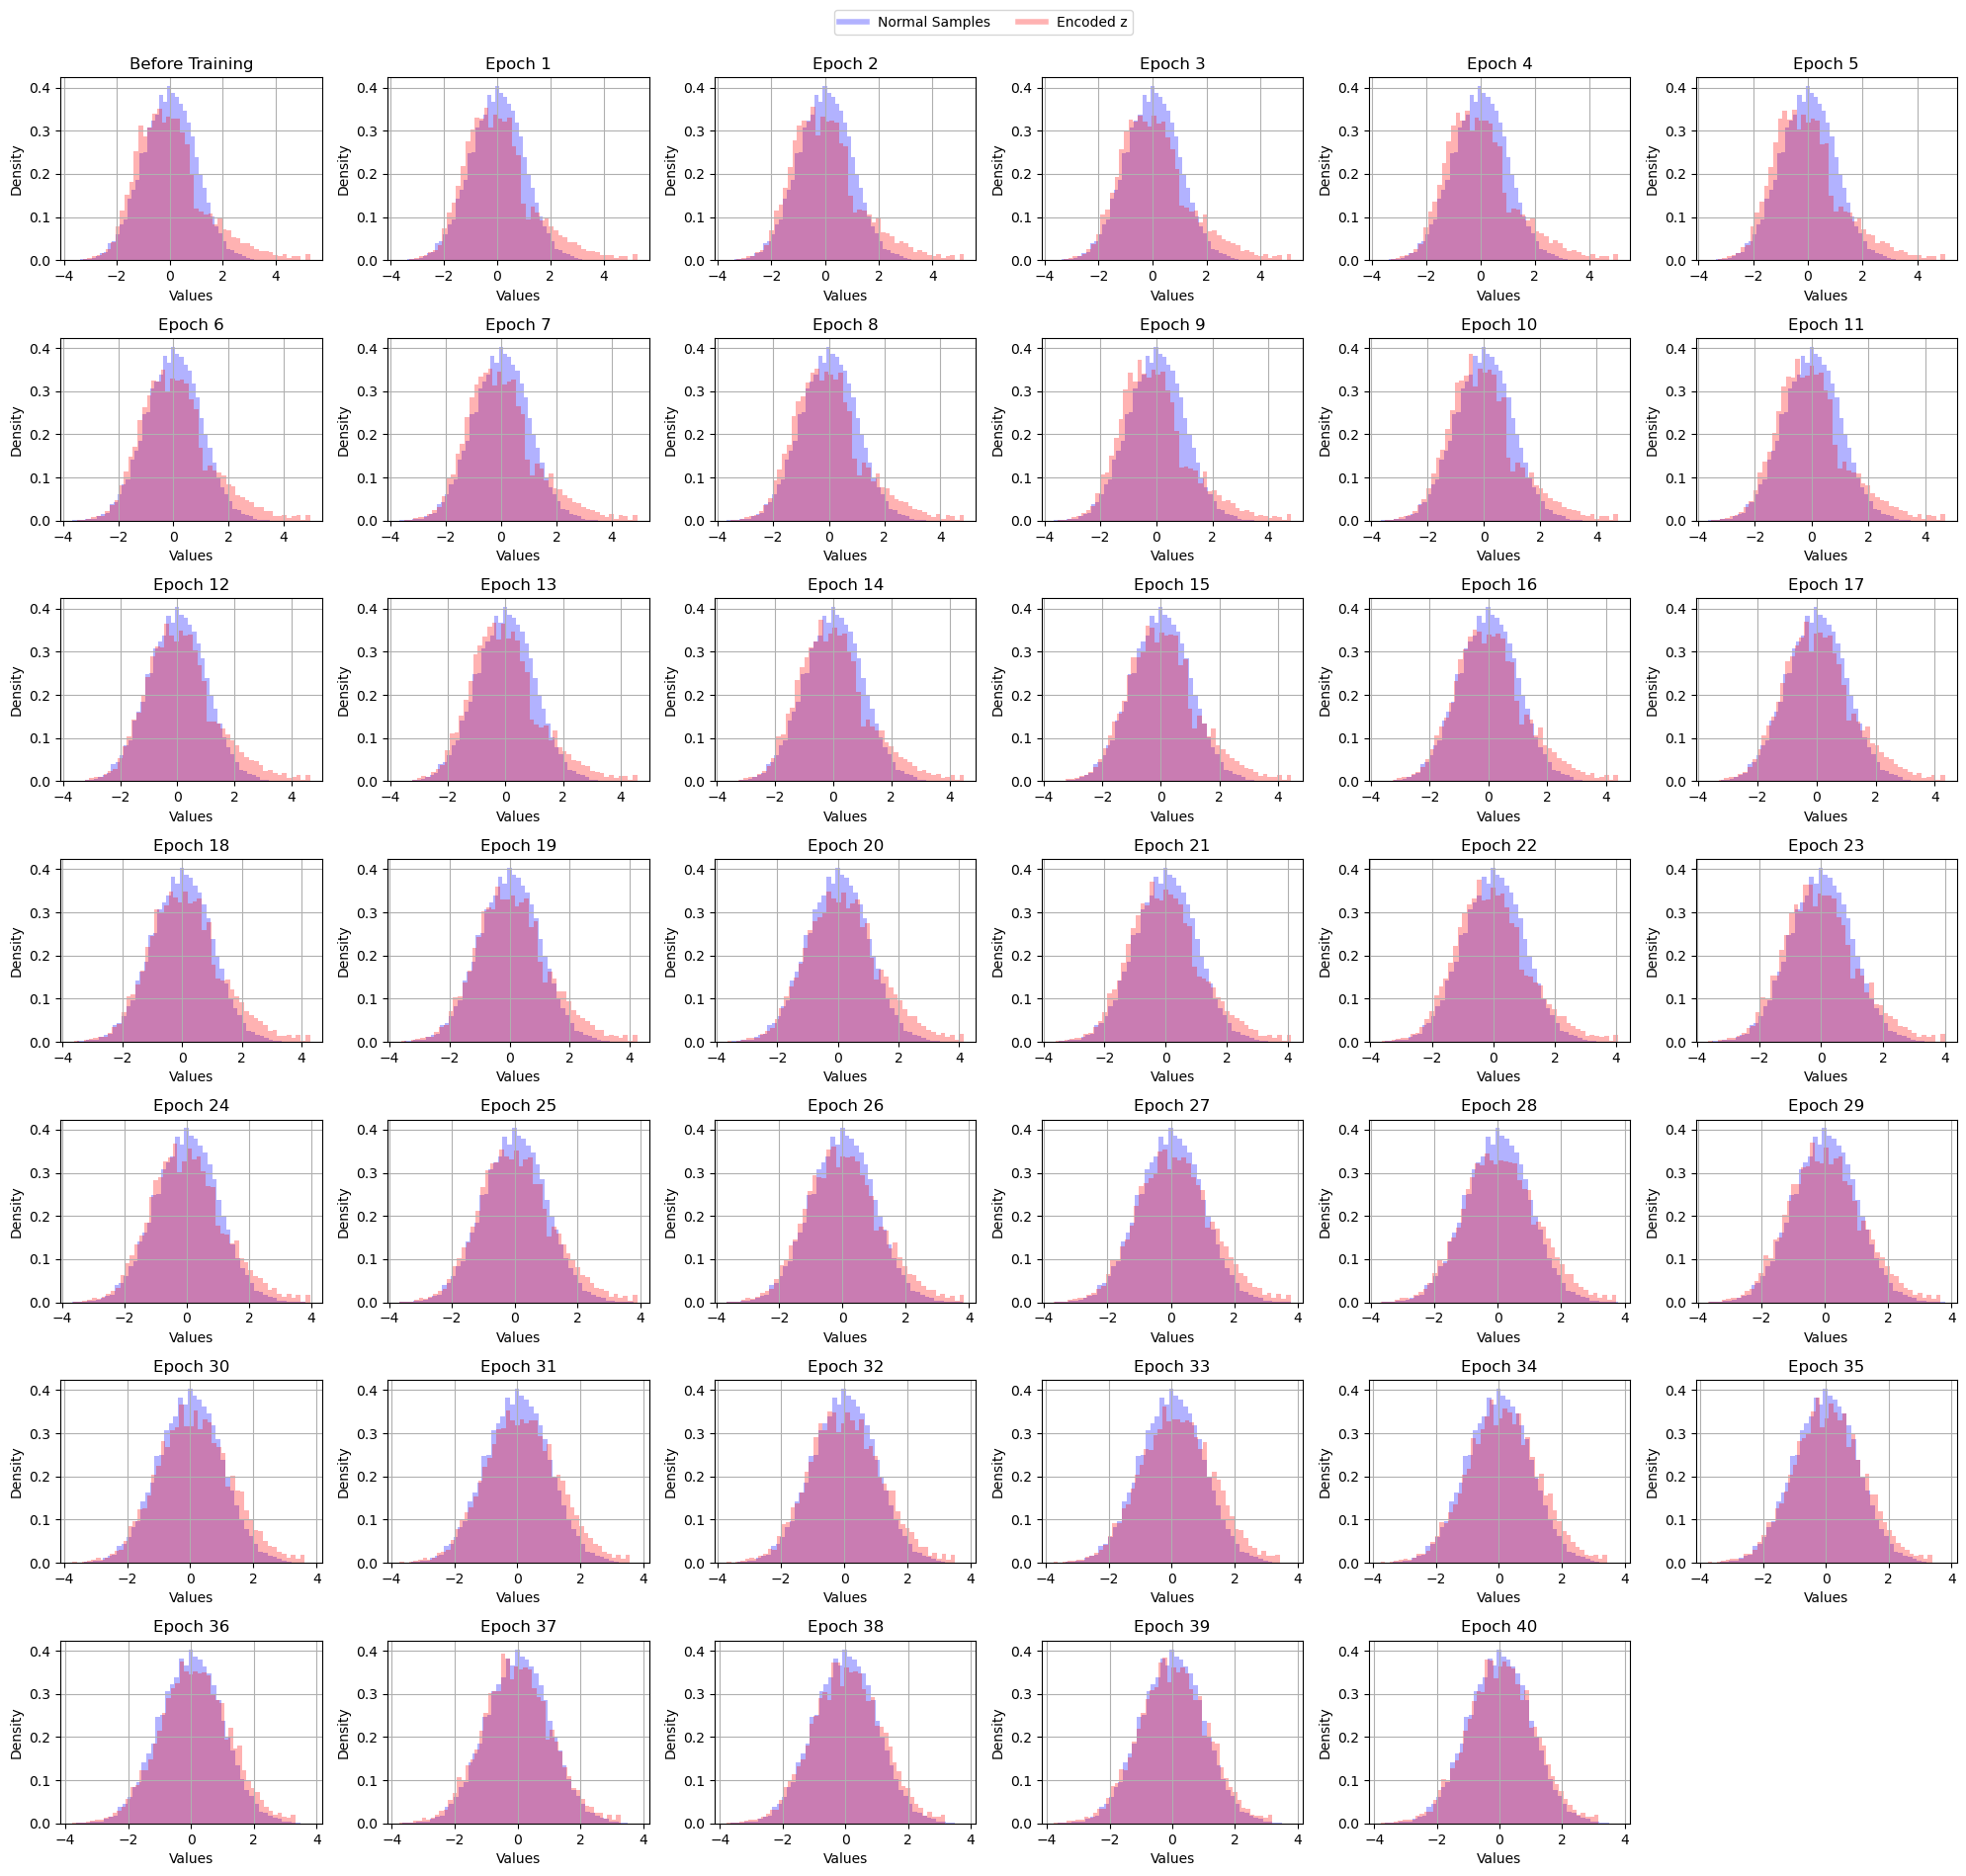

In [259]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data,
                model_params_list=epoch_wise_param_list,
                num_coeffs=5,print_model_params=0) # 40 more (30 below+40 below + 40 here = 70+40=110)

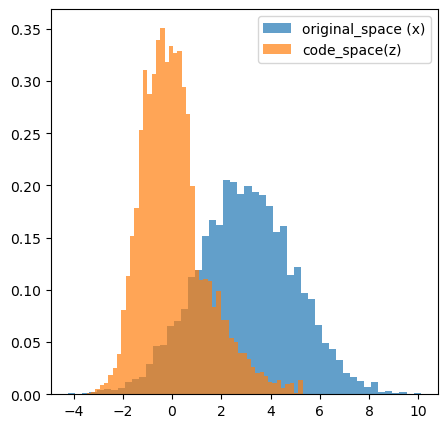

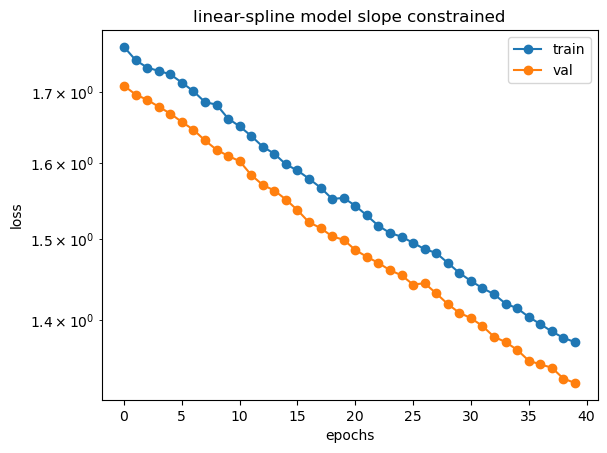

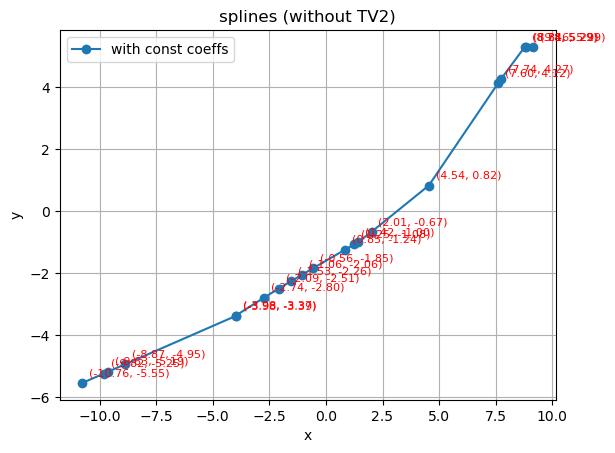

slopes: constrained coeffs: tensor([[0.3176, 0.3176, 0.3201, 0.3189, 0.3193, 3.0000, 0.4656, 0.4502, 0.4356,
         0.4315, 0.4270, 0.4250, 0.4190, 0.4521, 0.5538, 0.5913, 1.0779, 1.0415,
         0.9904, 0.0100, 0.0100]], grad_fn=<ClampBackward1>)


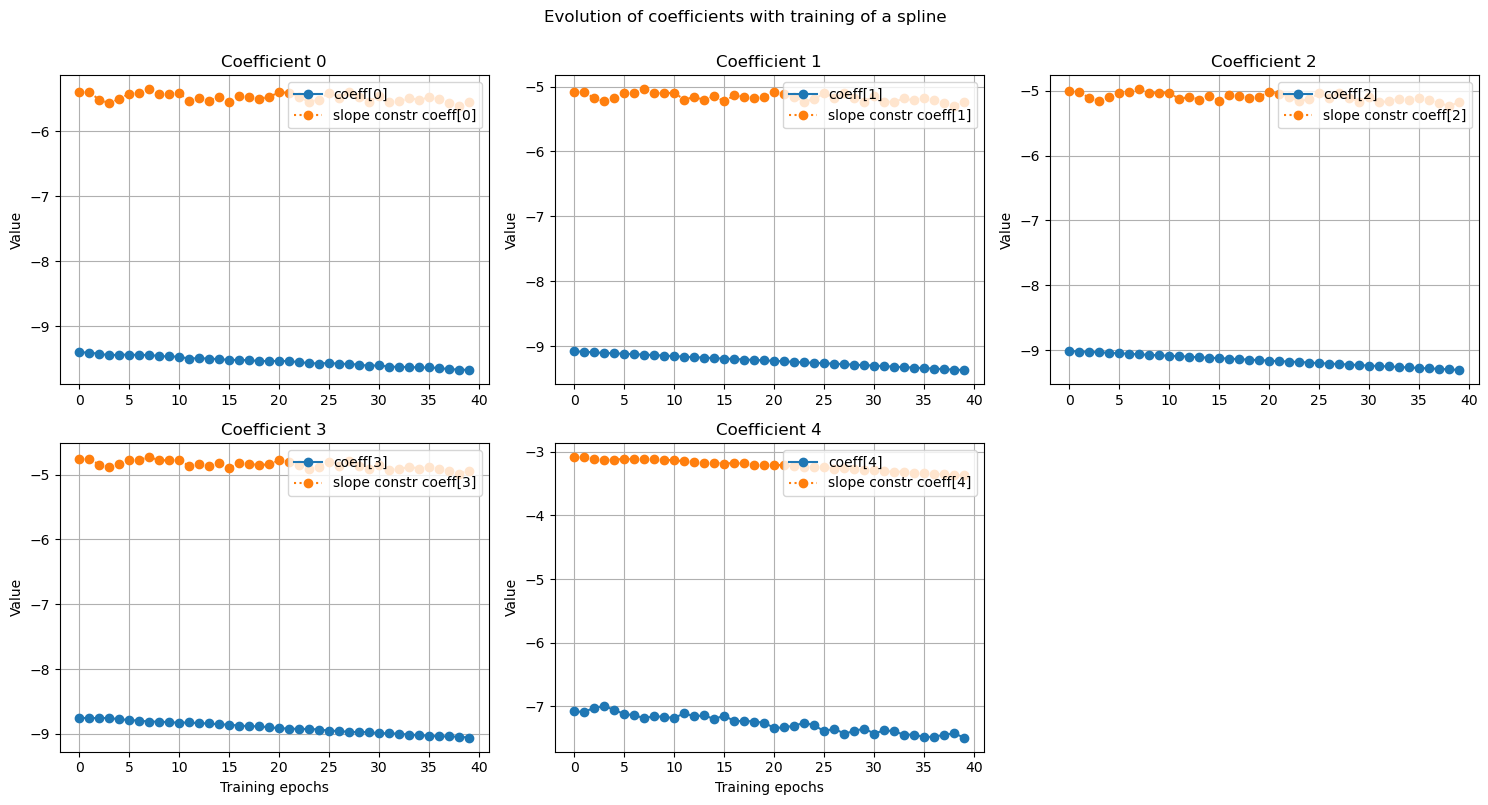

initial nodal_val_locs: tensor([[-10.7631,  -9.8174,  -9.6253,  -8.8662,  -3.9813,  -3.9771,  -2.7391,
          -2.0906,  -1.5254,  -1.0559,  -0.5623,   0.8543,   1.2473,   1.4213,
           2.0124,   4.5421,   7.6015,   7.7439,   8.7773,   8.8362,   9.1561]])
initial fn values: Parameter containing:
tensor([10.7631,  9.8174,  9.6253,  8.8662,  3.9813,  3.9771,  2.7391,  2.0906,
         1.5254,  1.0559,  0.5623,  0.8543,  1.2473,  1.4213,  2.0124,  4.5421,
         7.6015,  7.7439,  8.7773,  8.8362,  9.1561], requires_grad=True)


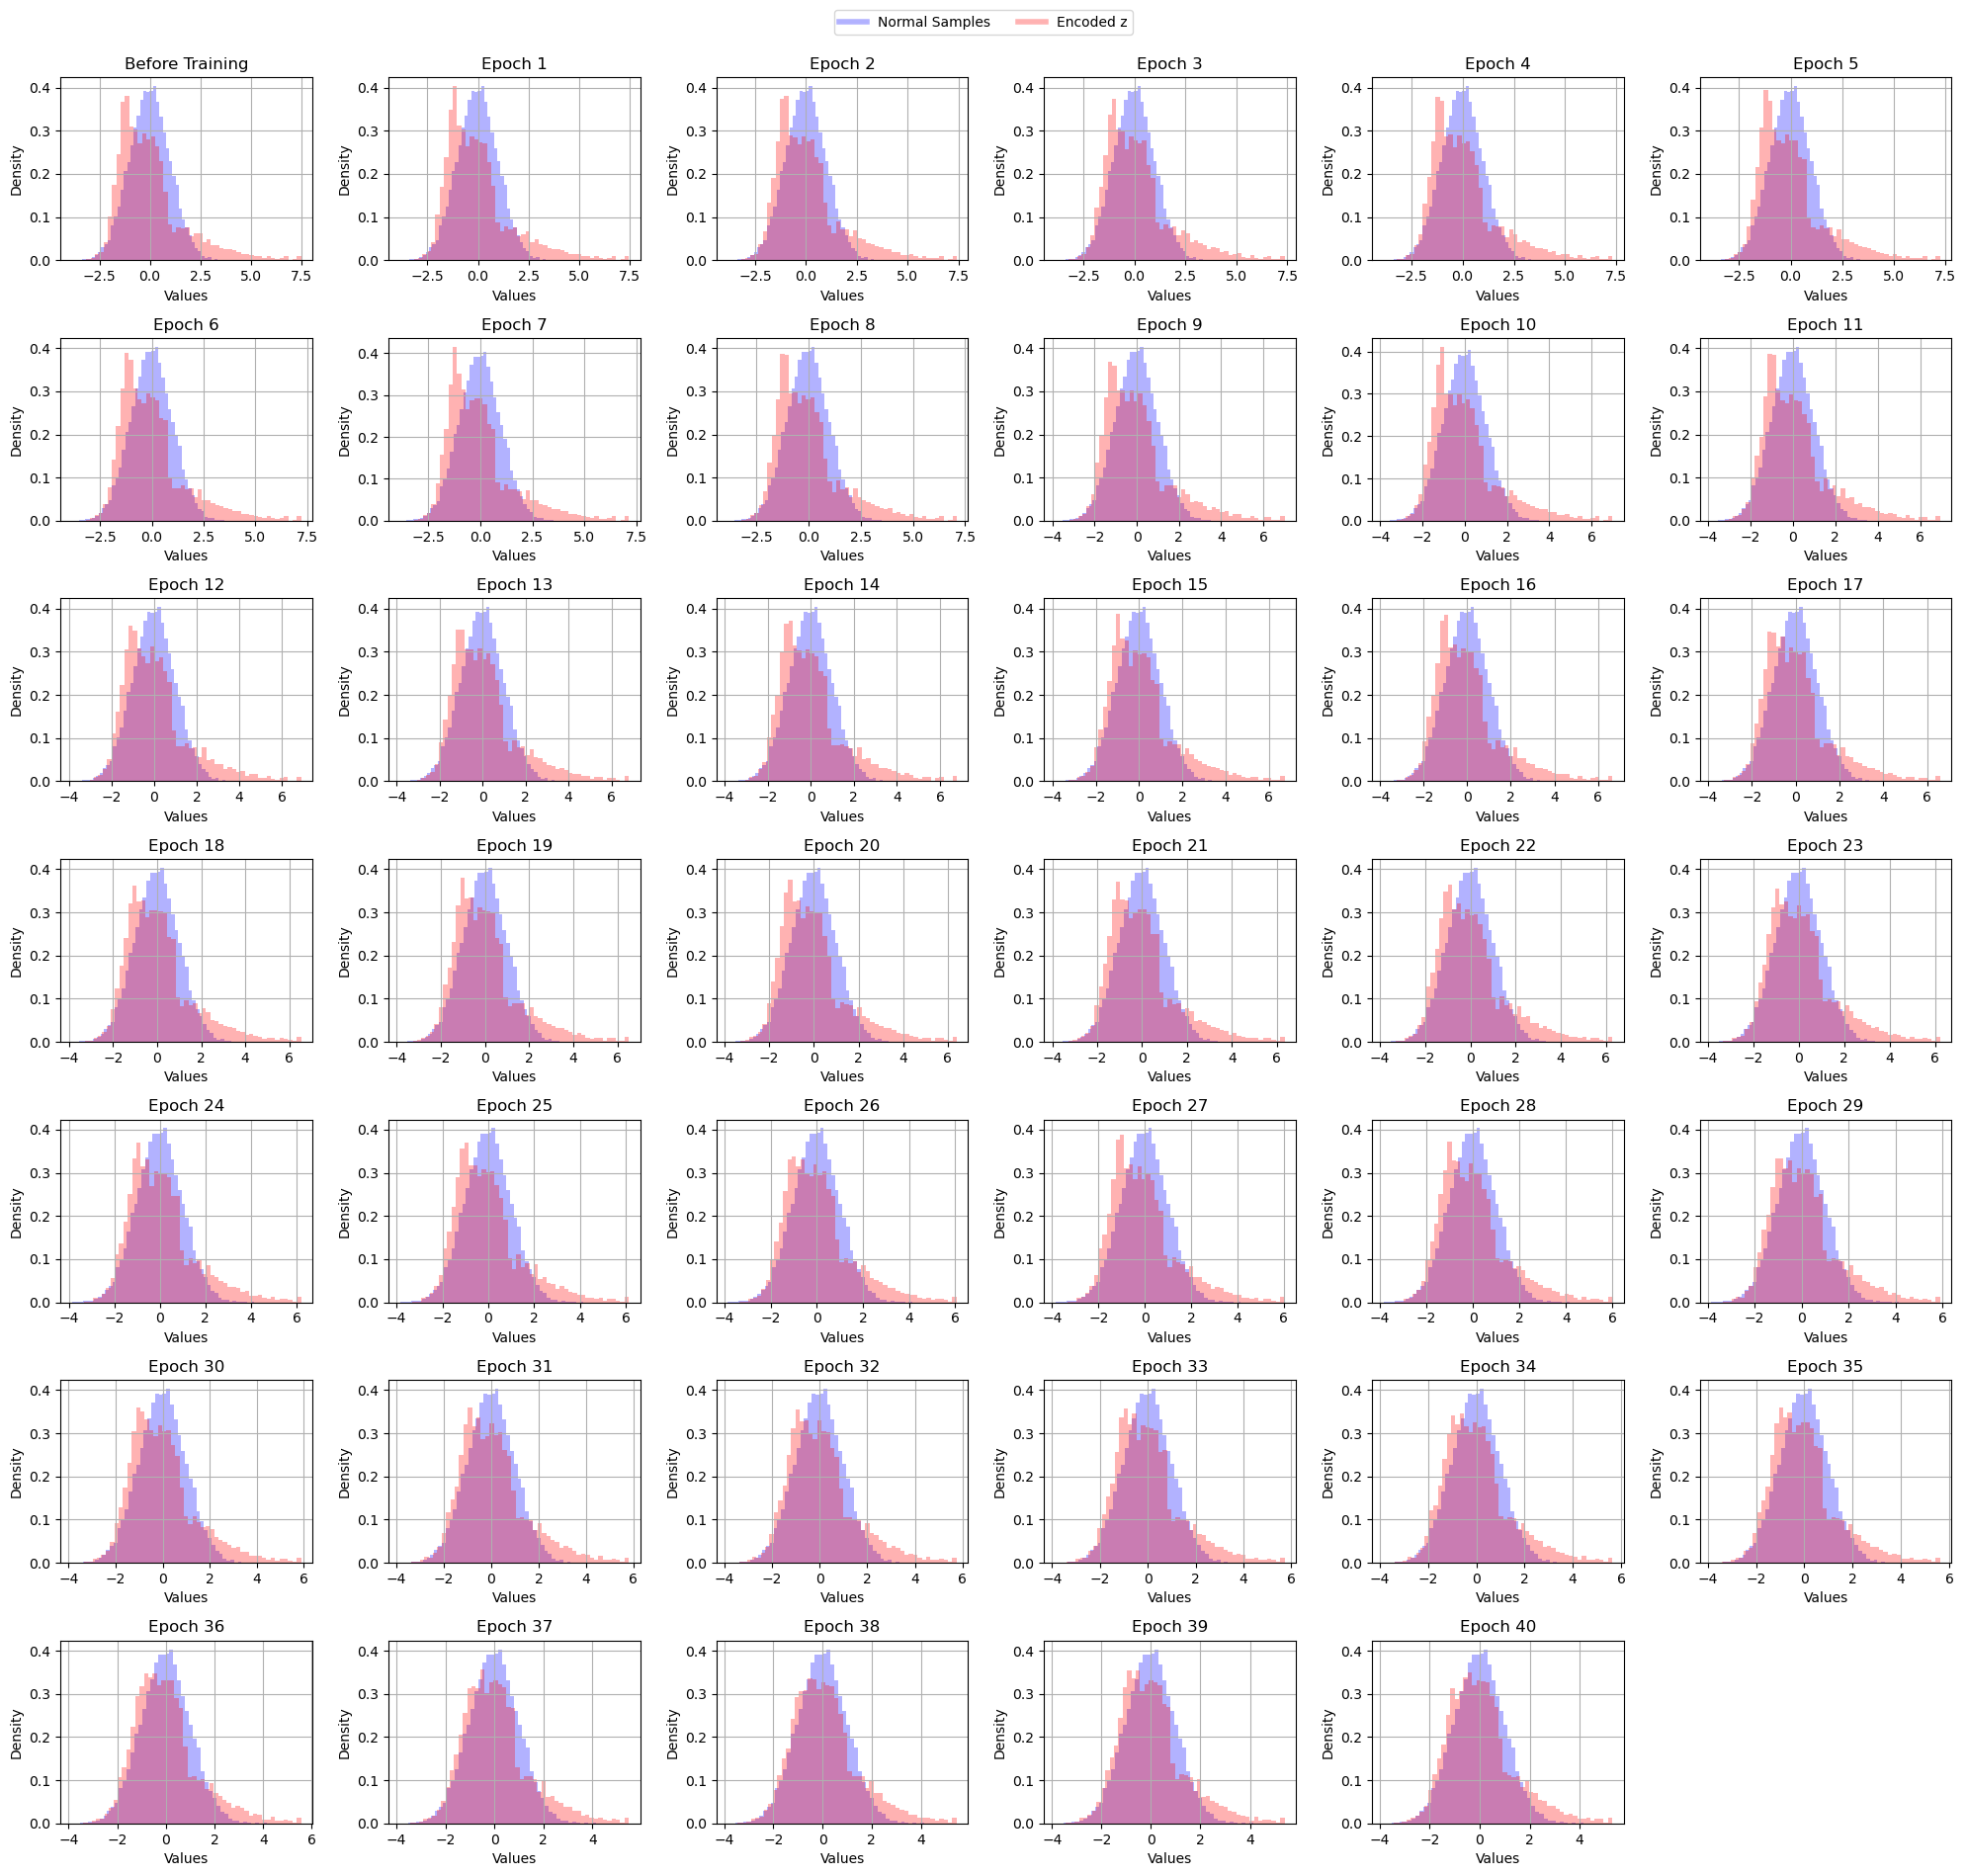

In [257]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data,
                model_params_list=epoch_wise_param_list,
                num_coeffs=5,print_model_params=0) # 40 more (30 below + 40 here = 70)

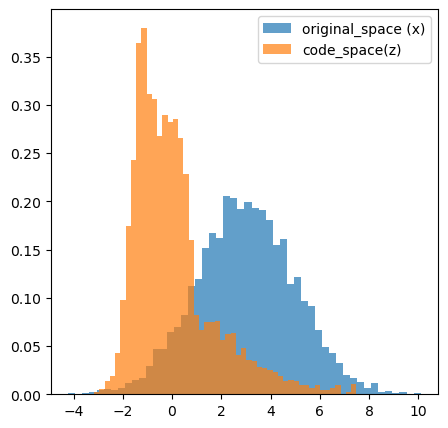

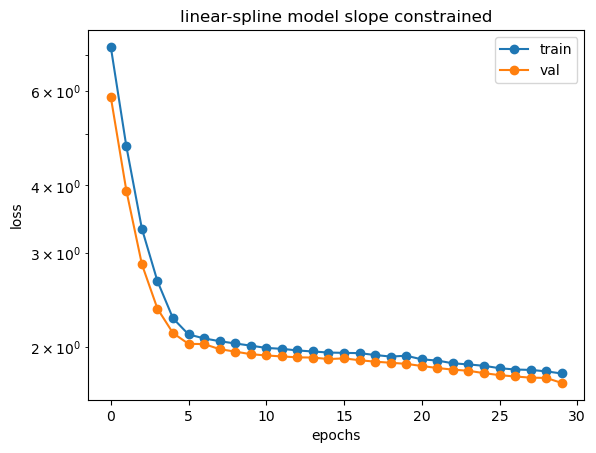

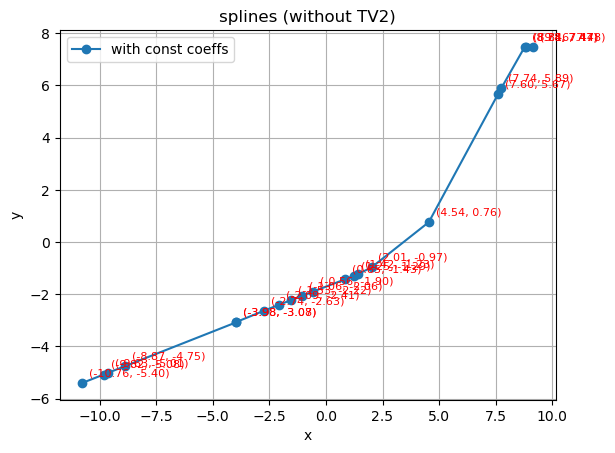

slopes: constrained coeffs: tensor([[0.3408, 0.3408, 0.3372, 0.3426, 0.3419, 3.0000, 0.3524, 0.3437, 0.3397,
         0.3373, 0.3337, 0.3319, 0.3358, 0.3690, 0.4382, 0.6848, 1.6044, 1.5748,
         1.5294, 0.0100, 0.0100]], grad_fn=<ClampBackward1>)


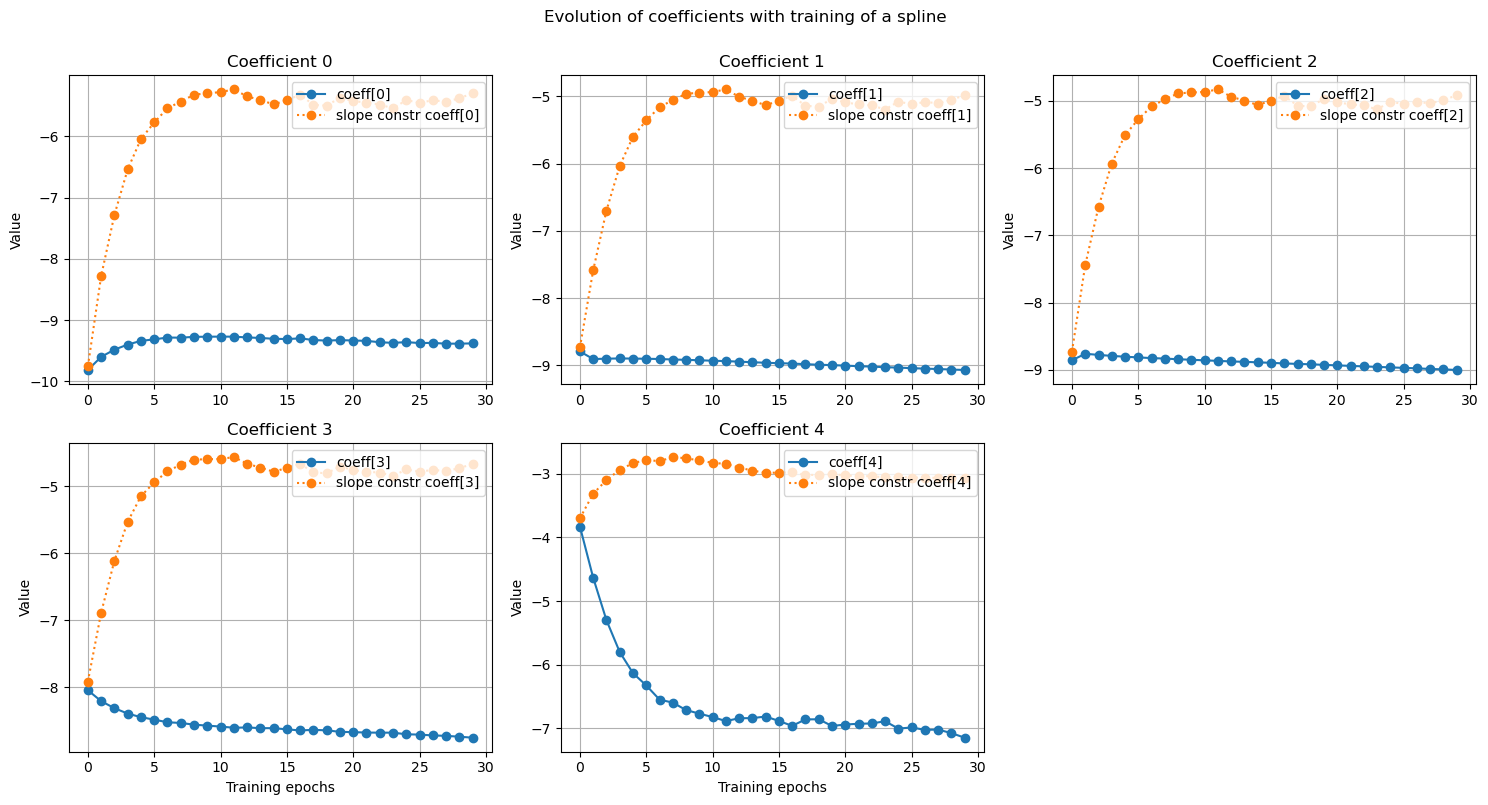

initial nodal_val_locs: tensor([[-10.7631,  -9.8174,  -9.6253,  -8.8662,  -3.9813,  -3.9771,  -2.7391,
          -2.0906,  -1.5254,  -1.0559,  -0.5623,   0.8543,   1.2473,   1.4213,
           2.0124,   4.5421,   7.6015,   7.7439,   8.7773,   8.8362,   9.1561]])
initial fn values: Parameter containing:
tensor([10.7631,  9.8174,  9.6253,  8.8662,  3.9813,  3.9771,  2.7391,  2.0906,
         1.5254,  1.0559,  0.5623,  0.8543,  1.2473,  1.4213,  2.0124,  4.5421,
         7.6015,  7.7439,  8.7773,  8.8362,  9.1561], requires_grad=True)


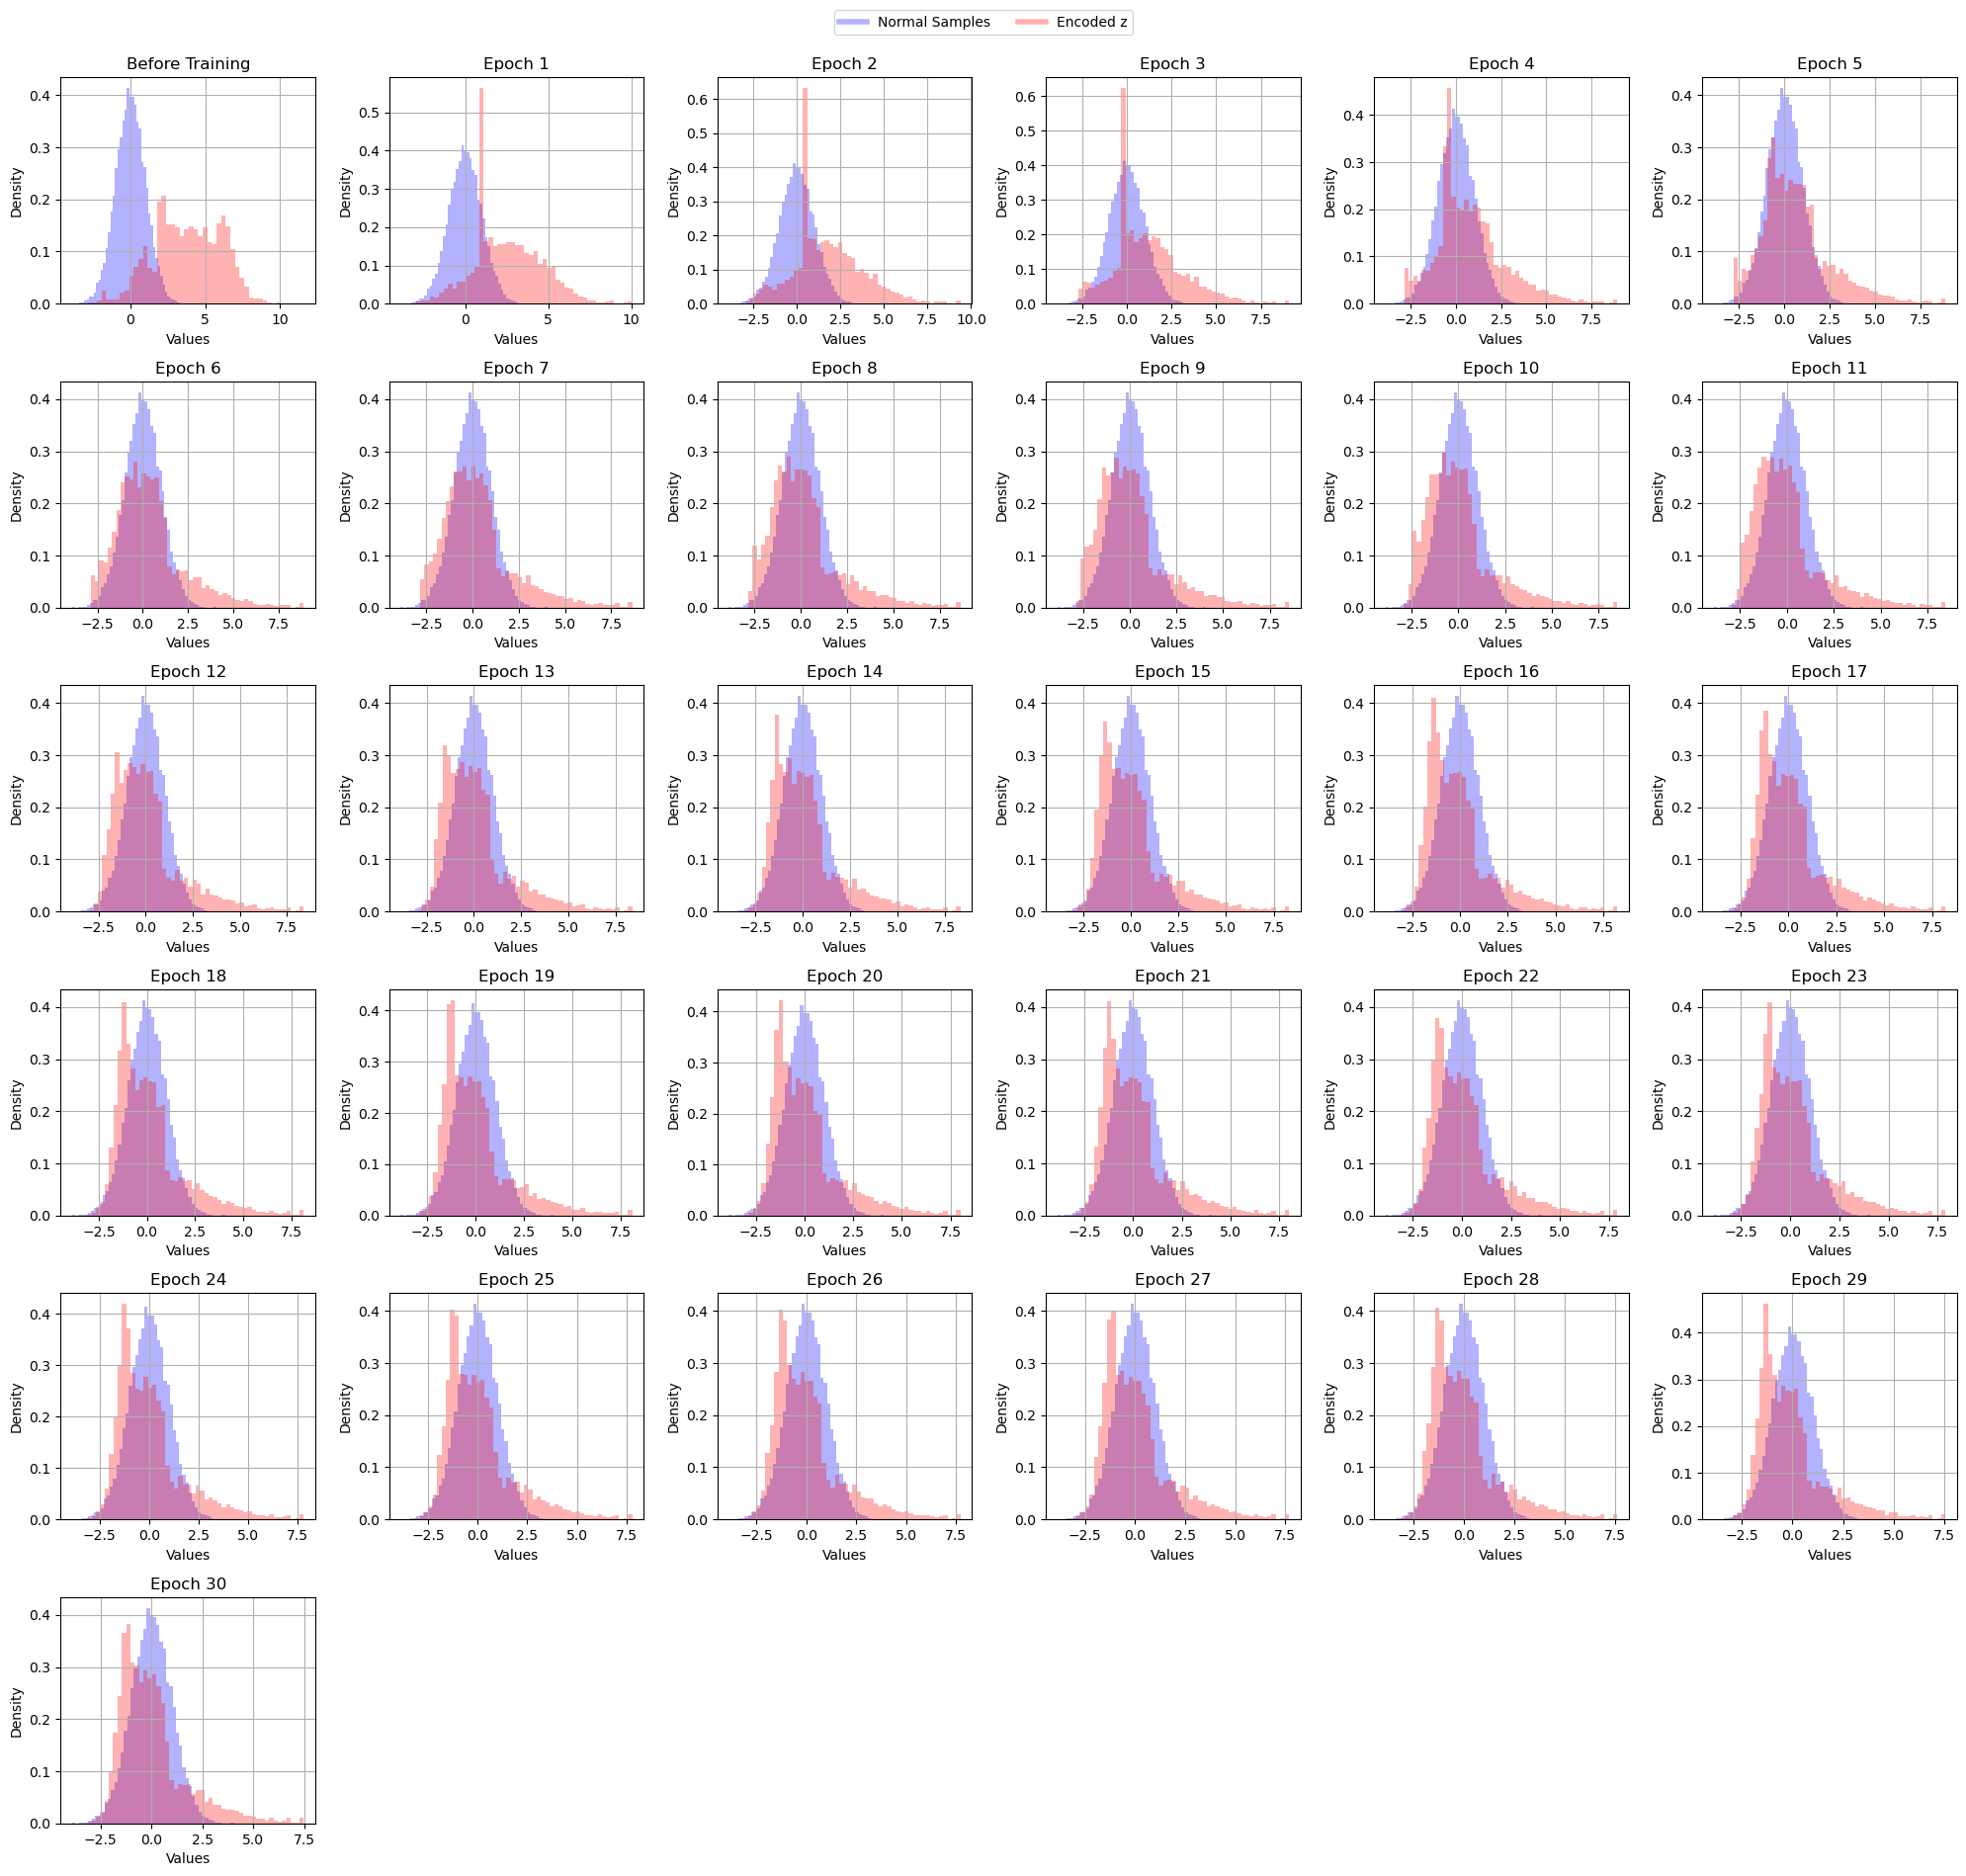

In [255]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data,
                model_params_list=epoch_wise_param_list,
                num_coeffs=5,print_model_params=0) 

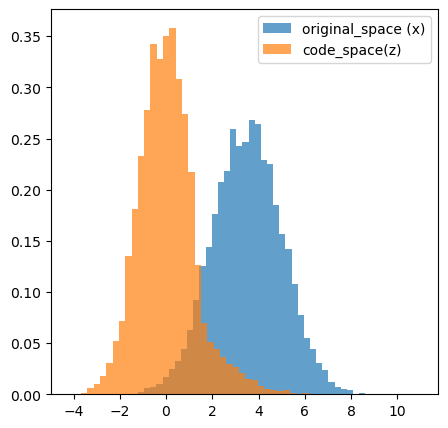

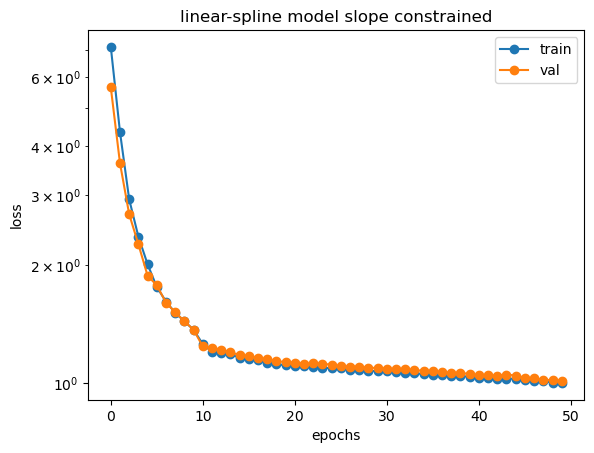

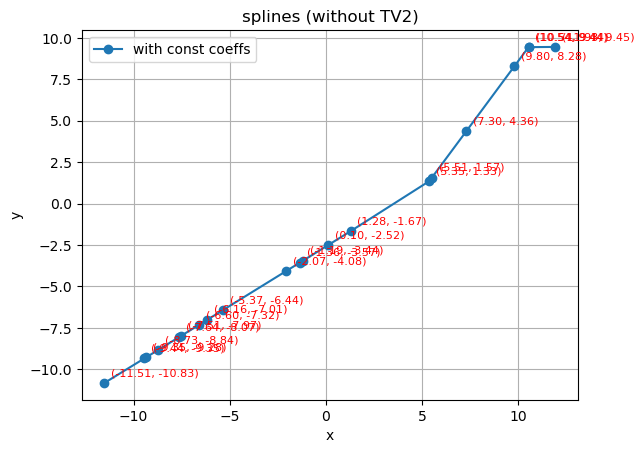

slopes: constrained coeffs: tensor([[0.7127, 0.7127, 0.7081, 0.7113, 0.7136, 0.7204, 0.7121, 0.7175, 0.7161,
         0.7168, 0.7170, 0.7088, 0.7195, 0.7196, 0.7383, 1.4328, 1.5661, 1.5684,
         1.5653, 0.0100, 0.0100]], grad_fn=<ClampBackward1>)


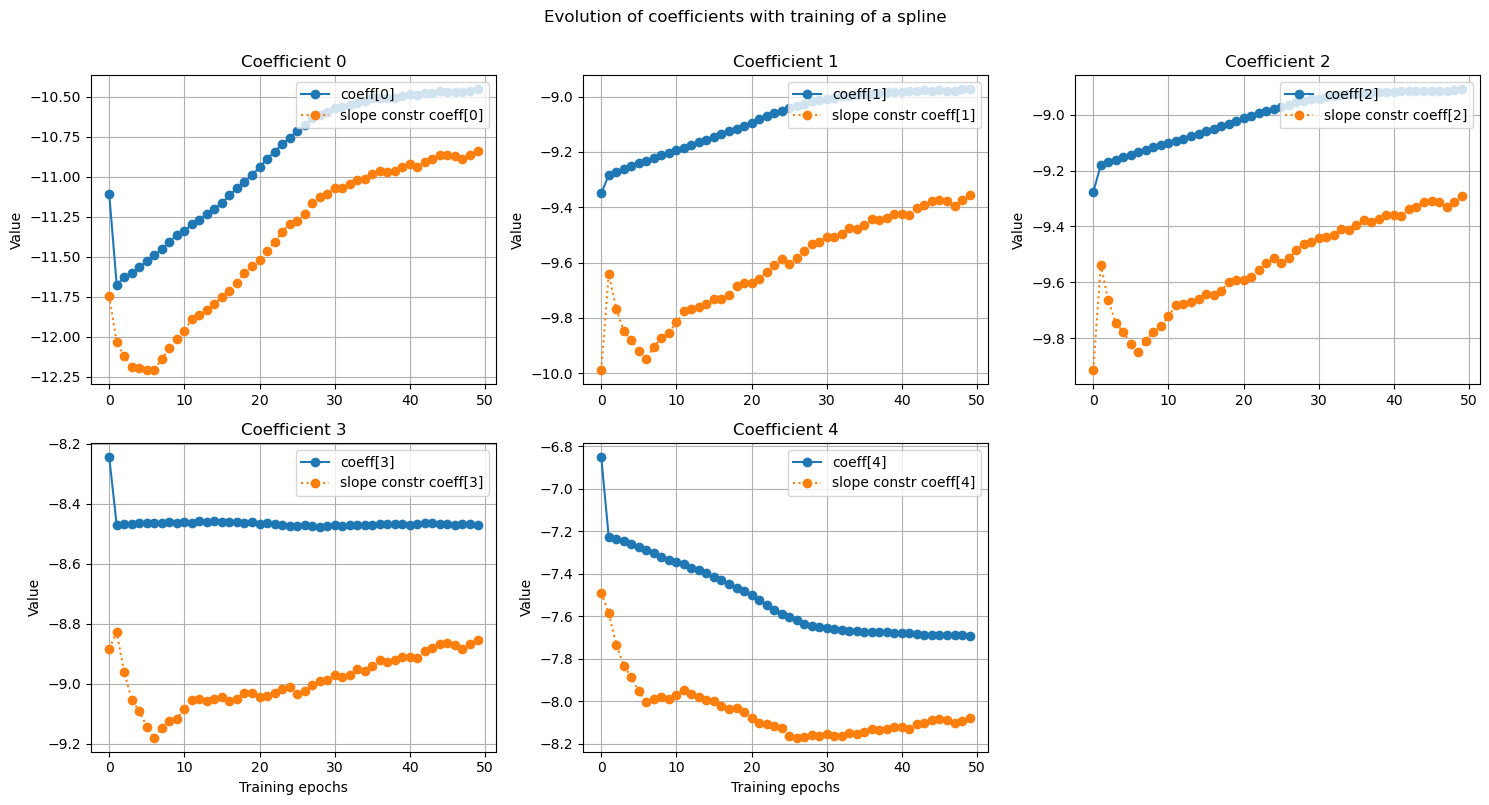

initial nodal_val_locs: tensor([[-11.5120,  -9.4373,  -9.3472,  -8.7287,  -7.6445,  -7.5106,  -6.5971,
          -6.1609,  -5.3714,  -2.0715,  -1.3621,  -1.1852,   0.1000,   1.2810,
           5.3507,   5.5124,   7.2956,   9.7962,  10.5365,  10.5391,  11.9307]])
initial fn values: Parameter containing:
tensor([11.5120,  9.4373,  9.3472,  8.7287,  7.6445,  7.5106,  6.5971,  6.1609,
         5.3714,  2.0715,  1.3621,  1.1852,  0.1000,  1.2810,  5.3507,  5.5124,
         7.2956,  9.7962, 10.5365, 10.5391, 11.9307], requires_grad=True)


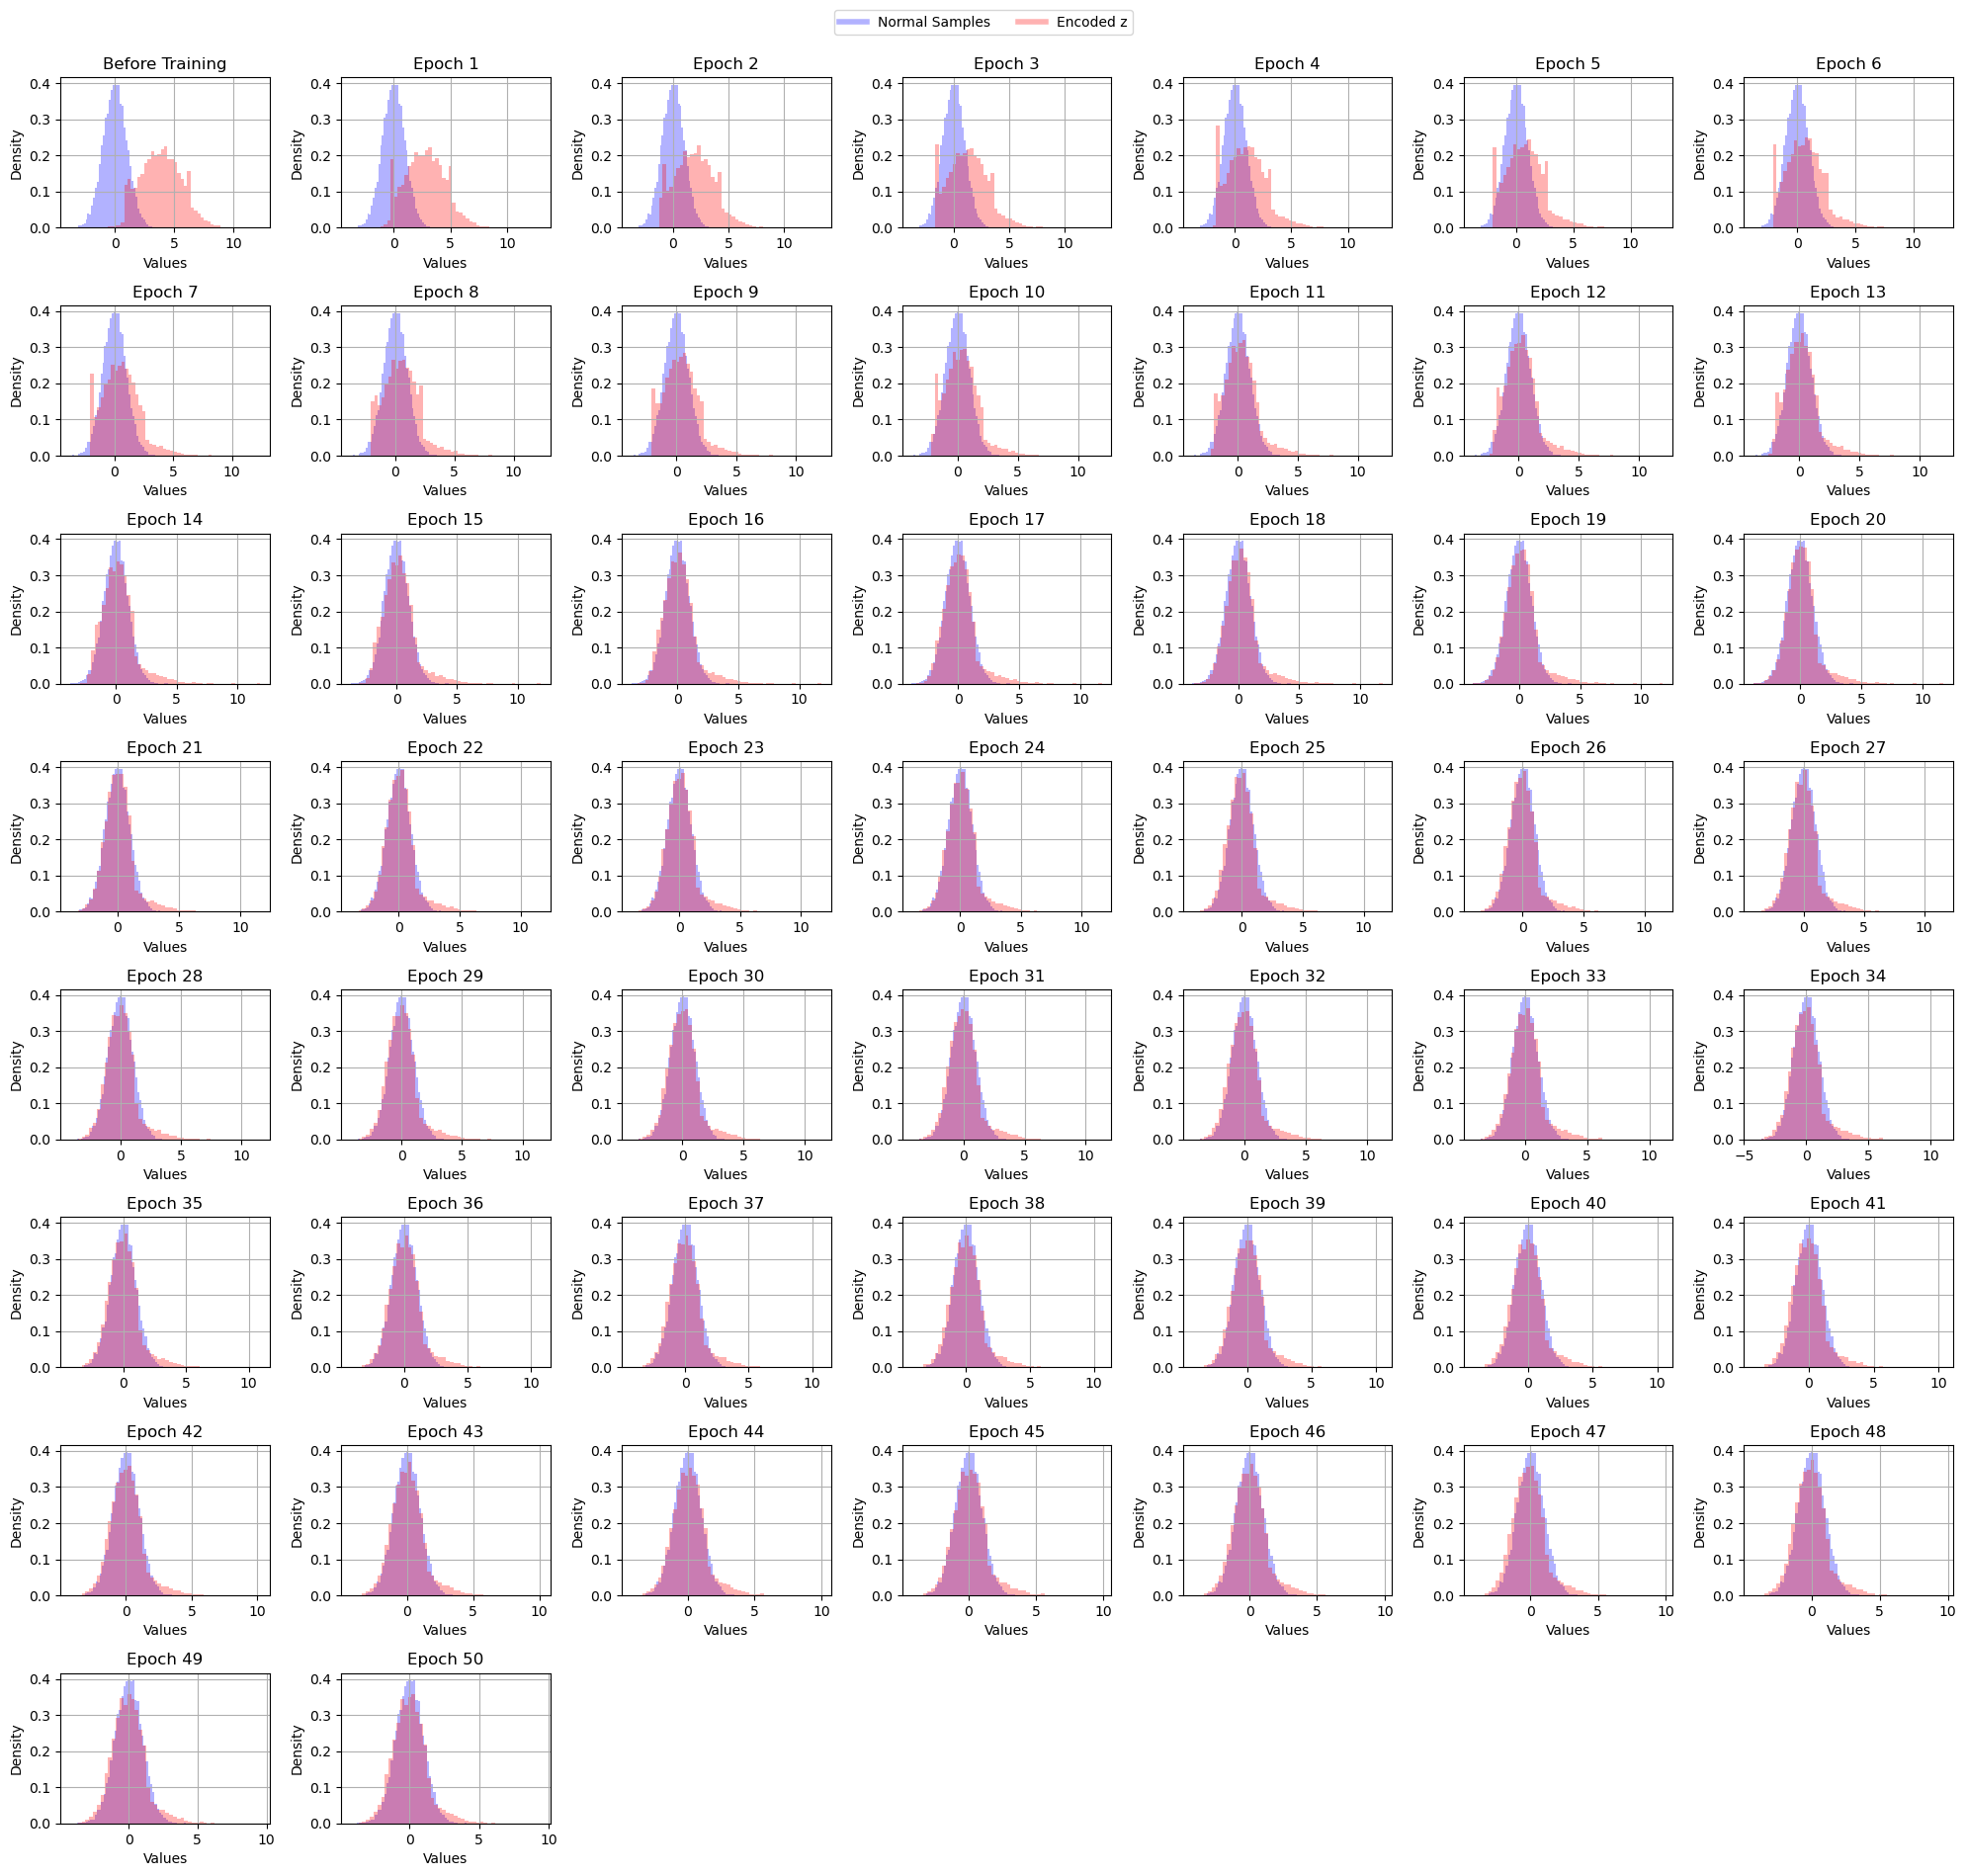

In [210]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data,
                model_params_list=epoch_wise_param_list,
                num_coeffs=5,print_model_params=0)

In [167]:
# let's train it for 20 more epochs and see how the training dynamics  further looks like
# training
train_loss2_1, val_loss2_1, epoch_wise_param_list_1,coeffs_unconstrained_evol2_1, coeffs_const_evol2_1 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=20,##40, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.005, # 
    print_after=1, #
    track_coefficients=1, # so yes, it indeed leads to something, however it is also quite dependent on the form of initialisation
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.01, # , #
    gamma = 0.5, # 
    alpha_nll=1)  

Training Progress:   5%|▌         | 1/20 [00:07<02:26,  7.71s/it]

Epoch 1/20,  train NLL+0.01XTV2: 2.457082279069083, data avg loss-1: 2.305488783121109 ,data avg loss-2: -0.10732169827712433 ,Training NLL Loss: 2.4128104817867277, Validation NLL Loss: 2.2128501240412395, LR: 0.005


Training Progress:  10%|█         | 2/20 [00:16<02:26,  8.13s/it]

Epoch 2/20,  train NLL+0.01XTV2: 2.140578411136355, data avg loss-1: 1.9161638459137509 ,data avg loss-2: -0.17336725760484115 ,Training NLL Loss: 2.0895311069488525, Validation NLL Loss: 1.9354879999160766, LR: 0.005


Training Progress:  15%|█▌        | 3/20 [00:23<02:15,  7.97s/it]

Epoch 3/20,  train NLL+0.01XTV2: 1.9697537842818669, data avg loss-1: 1.6881831182752336 ,data avg loss-2: -0.22613336735970474 ,Training NLL Loss: 1.9143164837360382, Validation NLL Loss: 1.808255929152171, LR: 0.005


Training Progress:  20%|██        | 4/20 [00:31<02:03,  7.74s/it]

Epoch 4/20,  train NLL+0.01XTV2: 1.8364495934758867, data avg loss-1: 1.520902885198593 ,data avg loss-2: -0.2606687266406204 ,Training NLL Loss: 1.7815716121877943, Validation NLL Loss: 1.686579974492391, LR: 0.005


Training Progress:  25%|██▌       | 5/20 [00:38<01:52,  7.50s/it]

Epoch 5/20,  train NLL+0.01XTV2: 1.7227510791165488, data avg loss-1: 1.3853441316740853 ,data avg loss-2: -0.2831658821819084 ,Training NLL Loss: 1.6685100143296379, Validation NLL Loss: 1.6215599608421325, LR: 0.005


Training Progress:  30%|███       | 6/20 [00:45<01:42,  7.31s/it]

Epoch 6/20,  train NLL+0.01XTV2: 1.6358004309449876, data avg loss-1: 1.2630137607029506 ,data avg loss-2: -0.31863781786390716 ,Training NLL Loss: 1.5816515781198228, Validation NLL Loss: 1.5316439294815063, LR: 0.005


Training Progress:  35%|███▌      | 7/20 [00:52<01:33,  7.21s/it]

Epoch 7/20,  train NLL+0.01XTV2: 1.4969956743717194, data avg loss-1: 1.0679031851461955 ,data avg loss-2: -0.37546589744942527 ,Training NLL Loss: 1.4433690779549735, Validation NLL Loss: 1.3648780433336893, LR: 0.005


Training Progress:  40%|████      | 8/20 [00:59<01:25,  7.12s/it]

Epoch 8/20,  train NLL+0.01XTV2: 1.3729088868413653, data avg loss-1: 0.872588077698435 ,data avg loss-2: -0.4473918706178665 ,Training NLL Loss: 1.3199799457618169, Validation NLL Loss: 1.2656170622507732, LR: 0.005


Training Progress:  45%|████▌     | 9/20 [01:06<01:17,  7.02s/it]

Epoch 9/20,  train NLL+0.01XTV2: 1.307307141678674, data avg loss-1: 0.7250592866965703 ,data avg loss-2: -0.5289653444290161 ,Training NLL Loss: 1.2540246260166168, Validation NLL Loss: 1.2272164789835611, LR: 0.005


Training Progress:  50%|█████     | 10/20 [01:13<01:10,  7.05s/it]

Epoch 10/20,  train NLL+0.01XTV2: 1.282029195853642, data avg loss-1: 0.6310163865770613 ,data avg loss-2: -0.5976066797120231 ,Training NLL Loss: 1.2286230676514762, Validation NLL Loss: 1.2158219186464945, LR: 0.005


Training Progress:  55%|█████▌    | 11/20 [01:20<01:03,  7.06s/it]

Epoch 11/20,  train NLL+0.01XTV2: 1.2775370386668614, data avg loss-1: 0.5463083162903786 ,data avg loss-2: -0.6764573844841548 ,Training NLL Loss: 1.2227657003062111, Validation NLL Loss: 1.2221644878387452, LR: 0.005


Training Progress:  60%|██████    | 12/20 [01:27<00:56,  7.04s/it]

Epoch 12/20,  train NLL+0.01XTV2: 1.2838005535943167, data avg loss-1: 0.48261235871485303 ,data avg loss-2: -0.7461120450496673 ,Training NLL Loss: 1.228724399123873, Validation NLL Loss: 1.230382821559906, LR: 0.005


Training Progress:  65%|██████▌   | 13/20 [01:34<00:48,  7.00s/it]

Epoch 13/20,  train NLL+0.01XTV2: 1.306086367538997, data avg loss-1: 0.41340241515210696 ,data avg loss-2: -0.836030603647232 ,Training NLL Loss: 1.2494330191612244, Validation NLL Loss: 1.2611611413955688, LR: 0.005


Training Progress:  70%|███████   | 14/20 [01:41<00:41,  6.99s/it]

Epoch 14/20,  train NLL+0.01XTV2: 1.3477526218550546, data avg loss-1: 0.35326816865376065 ,data avg loss-2: -0.9366740824495043 ,Training NLL Loss: 1.2899422512735639, Validation NLL Loss: 1.3148951101303101, LR: 0.0025


Training Progress:  75%|███████▌  | 15/20 [01:47<00:34,  6.94s/it]

Epoch 15/20,  train NLL+0.01XTV2: 1.3849845828328813, data avg loss-1: 0.3106156115233898 ,data avg loss-2: -1.016349867922919 ,Training NLL Loss: 1.326965478828975, Validation NLL Loss: 1.3444572019577026, LR: 0.0025


Training Progress:  80%|████████  | 16/20 [01:54<00:27,  6.94s/it]

Epoch 16/20,  train NLL+0.01XTV2: 1.3998384465490068, data avg loss-1: 0.2980400433710643 ,data avg loss-2: -1.0438385445731027 ,Training NLL Loss: 1.3418785854748316, Validation NLL Loss: 1.3443159612019857, LR: 0.0025


Training Progress:  85%|████████▌ | 17/20 [02:01<00:20,  6.90s/it]

Epoch 17/20,  train NLL+0.01XTV2: 1.4281513088090079, data avg loss-1: 0.2790310094079801 ,data avg loss-2: -1.0908548309121813 ,Training NLL Loss: 1.3698858397347586, Validation NLL Loss: 1.3864790900548298, LR: 0.00125


Training Progress:  90%|█████████ | 18/20 [02:08<00:13,  6.91s/it]

Epoch 18/20,  train NLL+0.01XTV2: 1.4531457192557198, data avg loss-1: 0.2635106140481574 ,data avg loss-2: -1.1312561627796718 ,Training NLL Loss: 1.3947667792865208, Validation NLL Loss: 1.4078219366073608, LR: 0.00125


Training Progress:  95%|█████████▌| 19/20 [02:15<00:06,  6.87s/it]

Epoch 19/20,  train NLL+0.01XTV2: 1.4816239442144121, data avg loss-1: 0.24852816678583622 ,data avg loss-2: -1.1743698348317828 ,Training NLL Loss: 1.4228979989460537, Validation NLL Loss: 1.4346964565912883, LR: 0.00125


Training Progress: 100%|██████████| 20/20 [02:22<00:00,  7.12s/it]

Epoch 20/20,  train NLL+0.01XTV2: 1.5043151249204363, data avg loss-1: 0.23941916411476477 ,data avg loss-2: -1.2060226823602405 ,Training NLL Loss: 1.445441846847534, Validation NLL Loss: 1.440671230951945, LR: 0.000625
Training complete


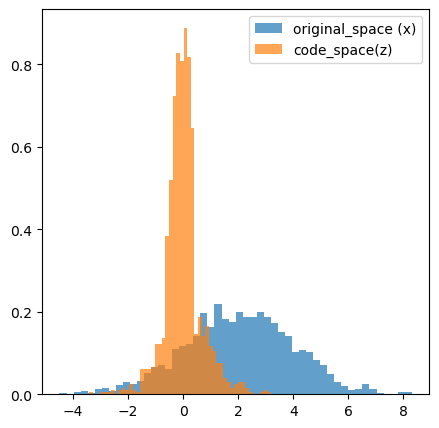

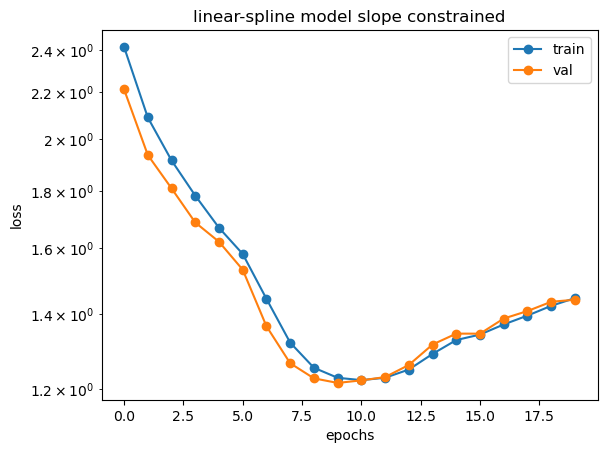

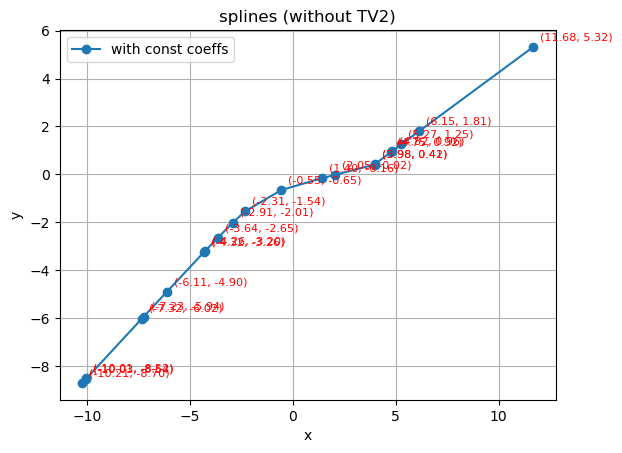

slopes: constrained coeffs: tensor([[0.9279, 0.9279, 0.9421, 0.9282, 0.9224, 0.9212, 0.9204, 0.8862, 0.8851,
         0.8770, 0.7871, 0.5049, 0.2503, 0.2232, 0.2233, 3.0000, 0.6455, 0.6444,
         0.6394, 0.6366, 0.6348]], grad_fn=<ClampBackward1>)


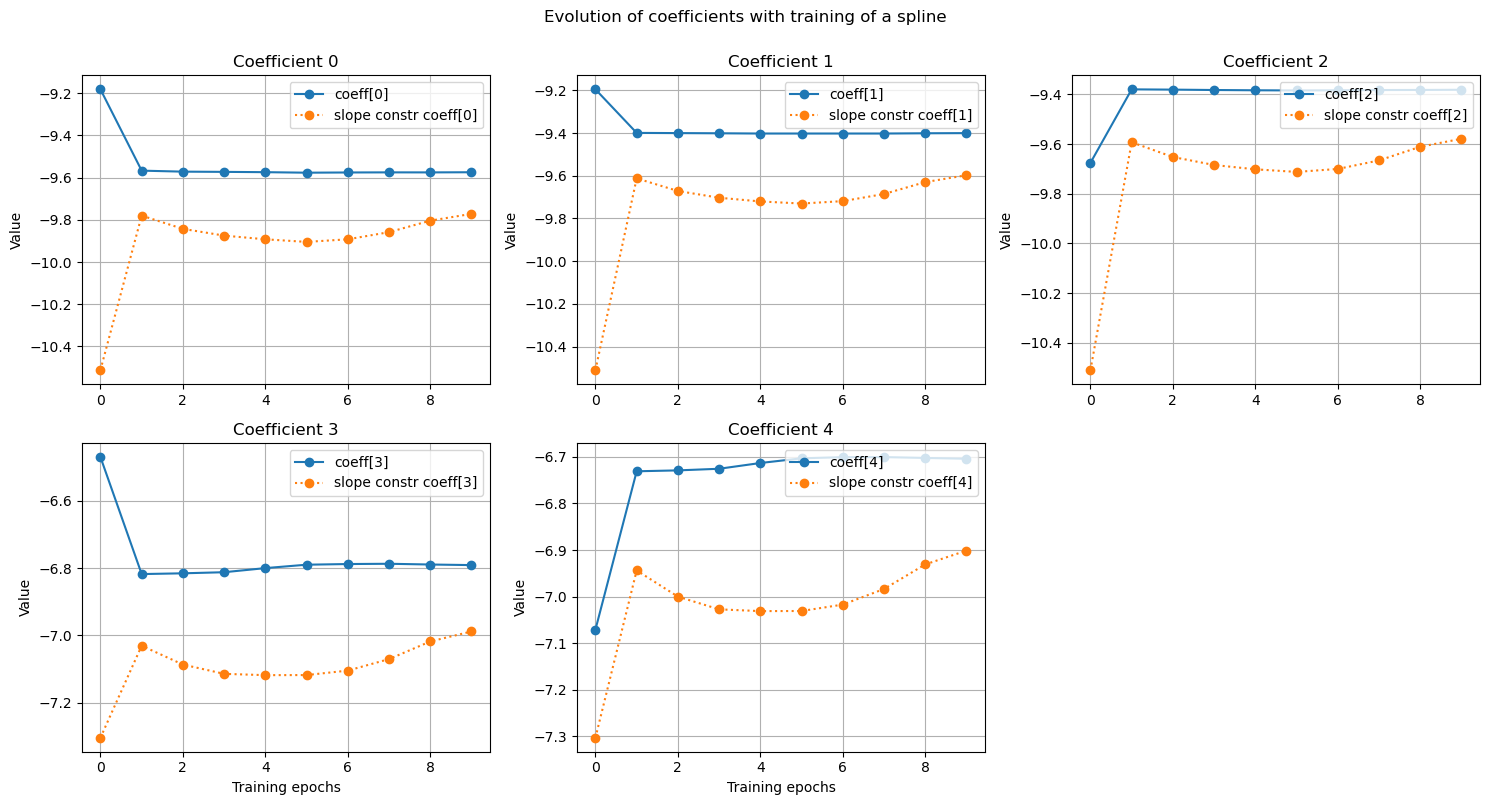

initial nodal_val_locs: tensor([[-10.2145, -10.0345, -10.0150,  -7.3240,  -7.2334,  -6.1086,  -4.3248,
          -4.2635,  -3.6371,  -2.9088,  -2.3126,  -0.5532,   1.4012,   2.0451,
           3.9759,   3.9795,   4.7485,   4.8165,   5.2681,   6.1474,  11.6755]])
initial fn values: Parameter containing:
tensor([10.2145, 10.0345, 10.0150,  7.3240,  7.2334,  6.1086,  4.3248,  4.2635,
         3.6371,  2.9088,  2.3126,  0.5532,  1.4012,  2.0451,  3.9759,  3.9795,
         4.7485,  4.8165,  5.2681,  6.1474, 11.6755], requires_grad=True)
{'coefficients_vect': tensor([-9.5721, -9.3996, -9.3808, -6.7932, -6.7065, -5.6346, -3.9407, -3.8826,
        -3.4199, -2.9735, -2.7015, -1.9003, -1.0176, -0.1541,  3.0711,  2.4657,
         3.2830,  3.3560,  3.8335,  4.7692, 10.7972])}
{'coefficients_vect': tensor([-9.5733, -9.3983, -9.3797, -6.7916, -6.7052, -5.6377, -3.9485, -3.9103,
        -3.5431, -3.1185, -2.8102, -1.9863, -1.0723, -0.2552,  2.6668,  2.4877,
         3.1748,  3.2352,  3.6933,  4.5843,

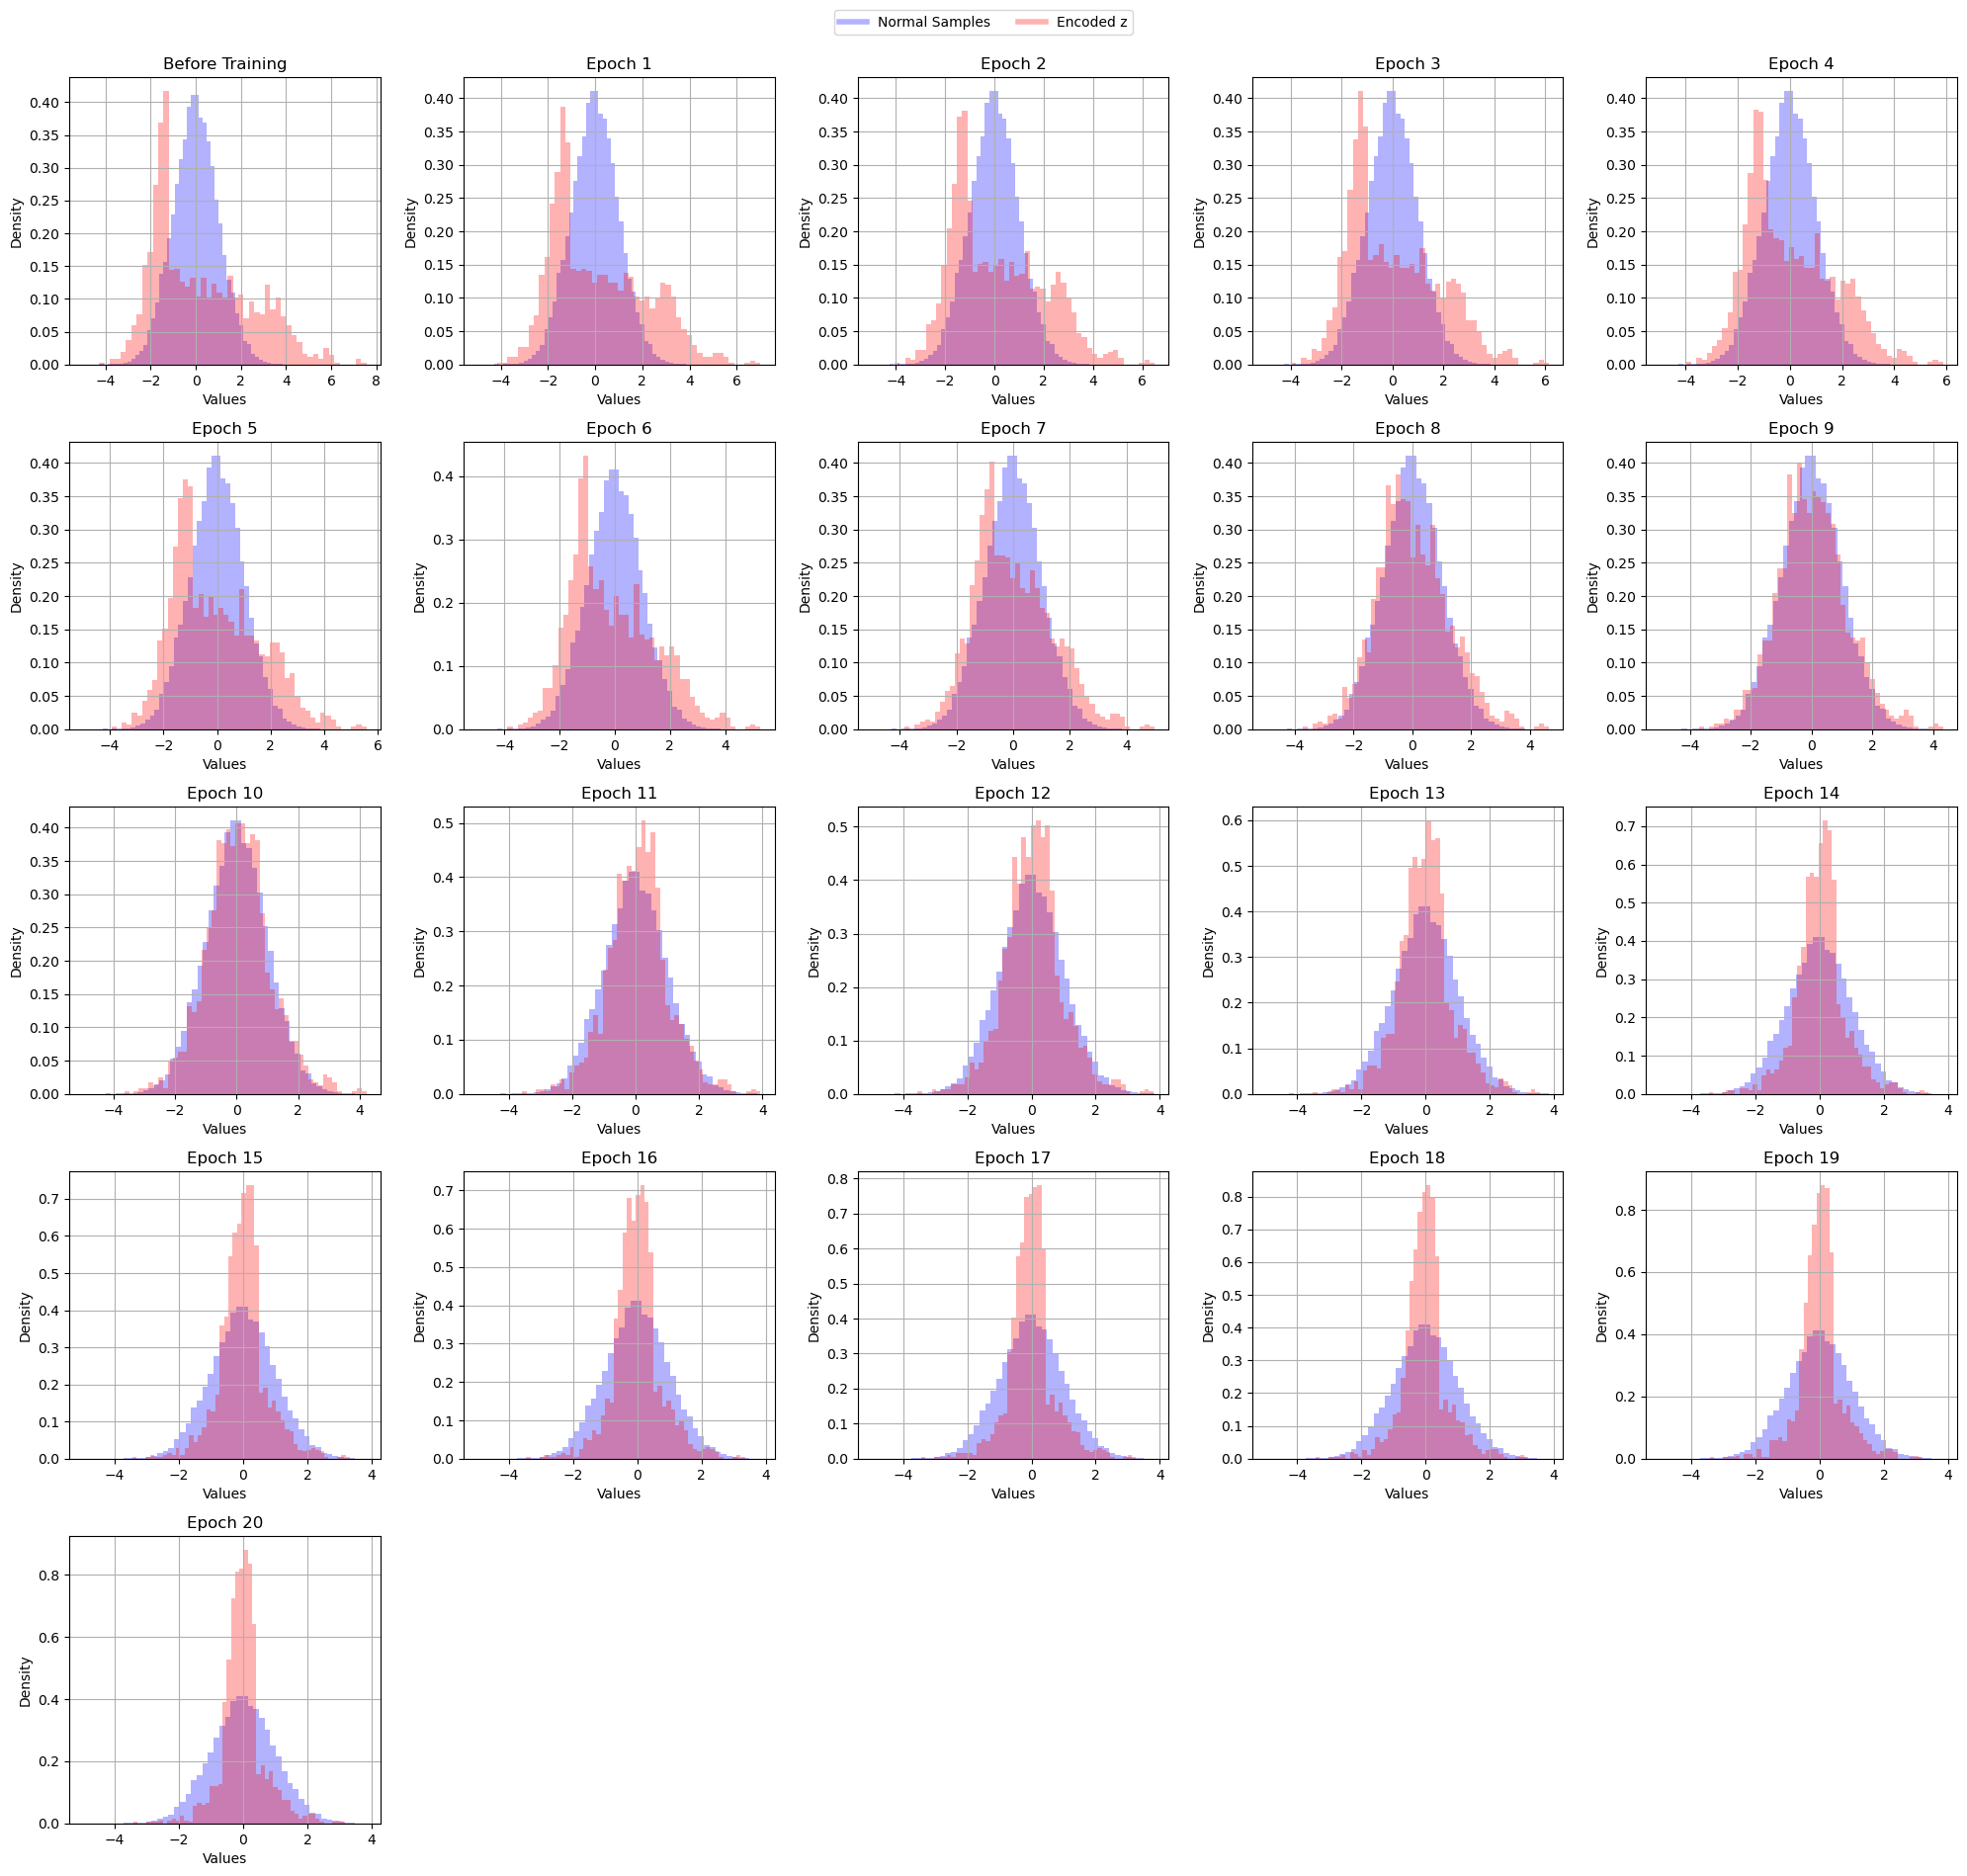

In [169]:
analyse_training(model_in=model2,
train_loss=train_loss2_1,#train_loss2+train_loss2_1,
val_loss=val_loss2_1,#val_loss2+val_loss2_1, 
model_params_list=epoch_wise_param_list_1,#epoch_wise_param_list + epoch_wise_param_list_1,
test_data=test_data, num_coeffs=5, print_model_params=1)

# IGNORE EVERYTHING BELOW FOR THE TIME BEING

In [444]:
train_loss21, val_loss21, coeffs_unconstrained_evol21, coeffs_const_evol21 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:26<06:15, 26.85s/it]

Epoch 1/15,  train NLL+2XTV2: 1.7950410302010171, Training NLL Loss: 1.7937681636140197, Validation NLL Loss: 1.675754126548767, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [00:51<05:35, 25.80s/it]

Epoch 2/15,  train NLL+2XTV2: 1.6104672450537139, Training NLL Loss: 1.6092781132372813, Validation NLL Loss: 1.5081323852539064, LR: 0.0005


Training Progress:  20%|██        | 3/15 [01:17<05:07, 25.62s/it]

Epoch 3/15,  train NLL+2XTV2: 1.4560924263570487, Training NLL Loss: 1.454889928492707, Validation NLL Loss: 1.3677404950857162, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [01:43<04:42, 25.66s/it]

Epoch 4/15,  train NLL+2XTV2: 1.329071256602638, Training NLL Loss: 1.32790742698345, Validation NLL Loss: 1.252764575123787, LR: 0.0005


Training Progress:  33%|███▎      | 5/15 [02:11<04:25, 26.58s/it]

Epoch 5/15,  train NLL+2XTV2: 1.2231665623422965, Training NLL Loss: 1.221948386796438, Validation NLL Loss: 1.1561619700193406, LR: 0.0005


Training Progress:  40%|████      | 6/15 [02:38<04:02, 26.92s/it]

Epoch 6/15,  train NLL+2XTV2: 1.1352590369483602, Training NLL Loss: 1.1340554538913128, Validation NLL Loss: 1.0762032825946808, LR: 0.0005


Training Progress:  47%|████▋     | 7/15 [03:01<03:23, 25.45s/it]

Epoch 7/15,  train NLL+2XTV2: 1.0613585530741152, Training NLL Loss: 1.0600970409421095, Validation NLL Loss: 1.009213008761406, LR: 0.0005


Training Progress:  53%|█████▎    | 8/15 [03:25<02:55, 25.06s/it]

Epoch 8/15,  train NLL+2XTV2: 1.0000129800478208, Training NLL Loss: 0.9988170198987668, Validation NLL Loss: 0.9547329425811768, LR: 0.0005


Training Progress:  60%|██████    | 9/15 [03:49<02:29, 24.86s/it]

Epoch 9/15,  train NLL+2XTV2: 0.9496789782498776, Training NLL Loss: 0.9485391789046536, Validation NLL Loss: 0.908453249335289, LR: 0.0005


Training Progress:  67%|██████▋   | 10/15 [04:13<02:02, 24.53s/it]

Epoch 10/15,  train NLL+2XTV2: 0.906641029836586, Training NLL Loss: 0.9054285443636119, Validation NLL Loss: 0.8690290504693985, LR: 0.0005


Training Progress:  73%|███████▎  | 11/15 [04:37<01:36, 24.21s/it]

Epoch 11/15,  train NLL+2XTV2: 0.8697649293867257, Training NLL Loss: 0.8686097119236564, Validation NLL Loss: 0.8363550344705581, LR: 0.0005


Training Progress:  80%|████████  | 12/15 [04:59<01:11, 23.68s/it]

Epoch 12/15,  train NLL+2XTV2: 0.839188279662259, Training NLL Loss: 0.8380170094731942, Validation NLL Loss: 0.8080475360155106, LR: 0.0005


Training Progress:  87%|████████▋ | 13/15 [05:22<00:46, 23.34s/it]

Epoch 13/15,  train NLL+2XTV2: 0.8120450075355062, Training NLL Loss: 0.8109037162354591, Validation NLL Loss: 0.7841522275209427, LR: 0.0005


Training Progress:  93%|█████████▎| 14/15 [05:45<00:23, 23.33s/it]

Epoch 14/15,  train NLL+2XTV2: 0.7901890381545007, Training NLL Loss: 0.7888947354746151, Validation NLL Loss: 0.764464368224144, LR: 0.0005


Training Progress: 100%|██████████| 15/15 [06:09<00:00, 24.63s/it]

Epoch 15/15,  train NLL+2XTV2: 0.7716132789569322, Training NLL Loss: 0.7703813072086504, Validation NLL Loss: 0.74839078271389, LR: 0.0005
Training complete


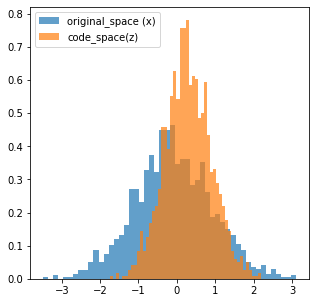

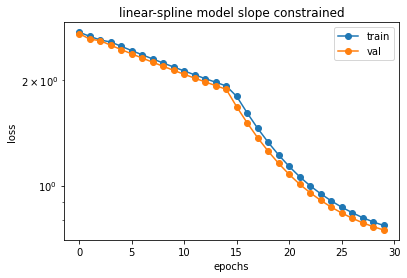

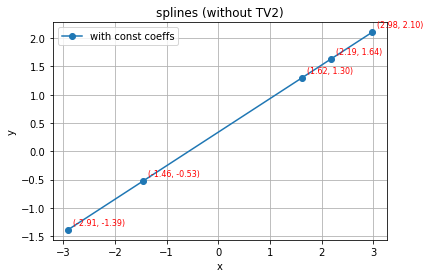

slopes: constrrained coeffs: tensor([[0.5933, 0.5933, 0.5930, 0.5930, 0.5928]], grad_fn=<ClampBackward1>)


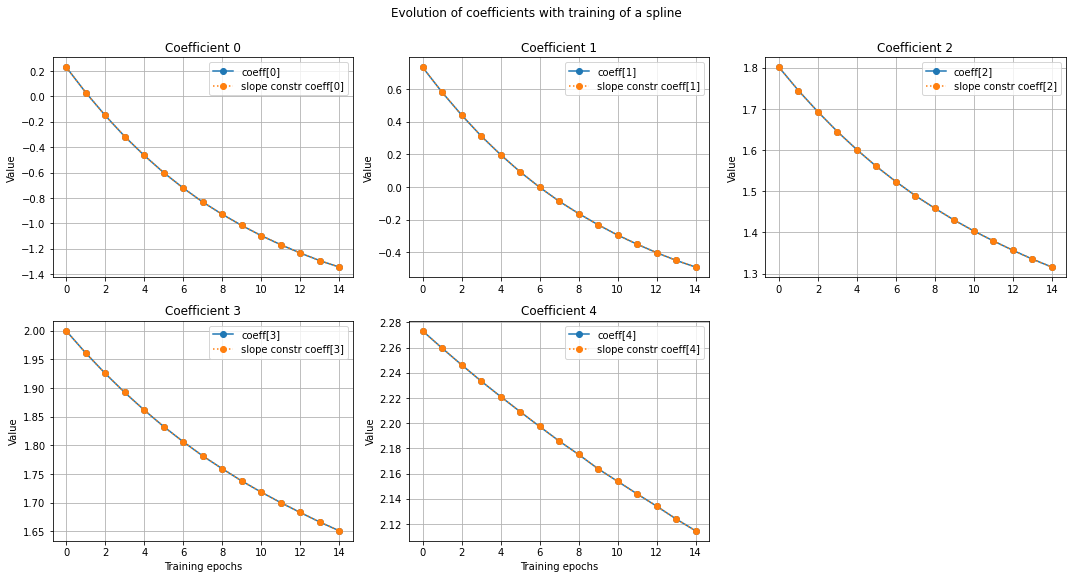

In [445]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

plot_loss_curves(train_loss=train_loss2+train_loss21, val_loss=val_loss2+val_loss21,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol21), 
                        np.array(coeffs_const_evol21), log_scale=0)

In [446]:
train_loss22, val_loss22, coeffs_unconstrained_evol22, coeffs_const_evol22 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:25<06:00, 25.75s/it]

Epoch 1/15,  train NLL+2XTV2: 0.7560859116459874, Training NLL Loss: 0.754804031375952, Validation NLL Loss: 0.7327845113277436, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [00:49<05:22, 24.83s/it]

Epoch 2/15,  train NLL+2XTV2: 0.7421065440470067, Training NLL Loss: 0.7408806334066922, Validation NLL Loss: 0.7220781663656235, LR: 0.0005


Training Progress:  20%|██        | 3/15 [01:11<04:39, 23.31s/it]

Epoch 3/15,  train NLL+2XTV2: 0.7314912248035732, Training NLL Loss: 0.7303401065260913, Validation NLL Loss: 0.712250748693943, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [01:35<04:18, 23.53s/it]

Epoch 4/15,  train NLL+2XTV2: 0.7227154010595577, Training NLL Loss: 0.7215110120373908, Validation NLL Loss: 0.7043339312076569, LR: 0.0005


Training Progress:  33%|███▎      | 5/15 [01:59<03:57, 23.71s/it]

Epoch 5/15,  train NLL+2XTV2: 0.7148955892372458, Training NLL Loss: 0.713751832286619, Validation NLL Loss: 0.6975123455524445, LR: 0.0005


Training Progress:  40%|████      | 6/15 [02:21<03:29, 23.24s/it]

Epoch 6/15,  train NLL+2XTV2: 0.7077750574091917, Training NLL Loss: 0.7065730575143321, Validation NLL Loss: 0.6915768585801124, LR: 0.0005


Training Progress:  47%|████▋     | 7/15 [02:44<03:04, 23.05s/it]

Epoch 7/15,  train NLL+2XTV2: 0.7021780178372229, Training NLL Loss: 0.7009775215167722, Validation NLL Loss: 0.6866017317771912, LR: 0.0005


Training Progress:  53%|█████▎    | 8/15 [03:05<02:38, 22.60s/it]

Epoch 8/15,  train NLL+2XTV2: 0.6972290485484435, Training NLL Loss: 0.6960798933425313, Validation NLL Loss: 0.6822464079260826, LR: 0.0005


Training Progress:  60%|██████    | 9/15 [03:32<02:22, 23.74s/it]

Epoch 9/15,  train NLL+2XTV2: 0.6931972280208535, Training NLL Loss: 0.6920671766654181, Validation NLL Loss: 0.6788052502274513, LR: 0.0005


Training Progress:  67%|██████▋   | 10/15 [03:53<01:55, 23.05s/it]

Epoch 10/15,  train NLL+2XTV2: 0.690067335580186, Training NLL Loss: 0.6888967712362709, Validation NLL Loss: 0.6763396837711334, LR: 0.0005


Training Progress:  73%|███████▎  | 11/15 [04:15<01:30, 22.56s/it]

Epoch 11/15,  train NLL+2XTV2: 0.6874052545354217, Training NLL Loss: 0.686176716400296, Validation NLL Loss: 0.6739527670145035, LR: 0.0005


Training Progress:  80%|████████  | 12/15 [04:38<01:08, 22.85s/it]

Epoch 12/15,  train NLL+2XTV2: 0.6855675144106685, Training NLL Loss: 0.6843118056488936, Validation NLL Loss: 0.6725790653824806, LR: 0.0005


Training Progress:  87%|████████▋ | 13/15 [05:01<00:45, 22.94s/it]

Epoch 13/15,  train NLL+2XTV2: 0.6838009949795896, Training NLL Loss: 0.682651421570737, Validation NLL Loss: 0.671684087574482, LR: 0.0005


Training Progress:  93%|█████████▎| 14/15 [05:23<00:22, 22.42s/it]

Epoch 14/15,  train NLL+2XTV2: 0.6824377398130316, Training NLL Loss: 0.6812830328456132, Validation NLL Loss: 0.6705488206744195, LR: 0.0005


Training Progress: 100%|██████████| 15/15 [05:44<00:00, 22.97s/it]

Epoch 15/15,  train NLL+2XTV2: 0.6818717758218346, Training NLL Loss: 0.6807398316103266, Validation NLL Loss: 0.6704583894014359, LR: 0.0005
Training complete


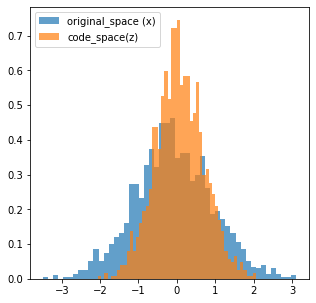

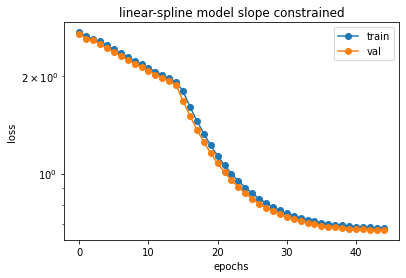

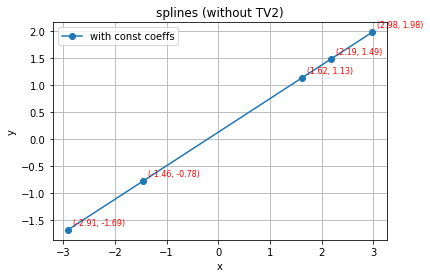

slopes: constrrained coeffs: tensor([[0.6224, 0.6224, 0.6223, 0.6225, 0.6224]], grad_fn=<ClampBackward1>)


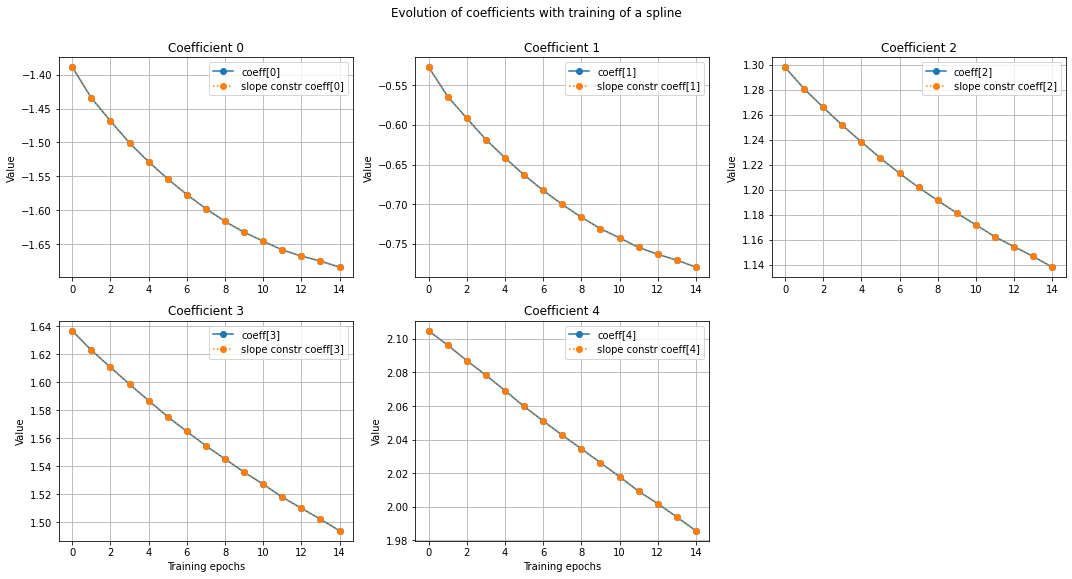

In [449]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

plot_loss_curves(train_loss=train_loss2+train_loss21+train_loss22, val_loss=val_loss2+val_loss21+val_loss22,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol22), 
                        np.array(coeffs_const_evol22), log_scale=0)

# everything below is for the negative nodal values case

UPDATE: after using TV2 regularisation, I dont know how correct these conclusions are?

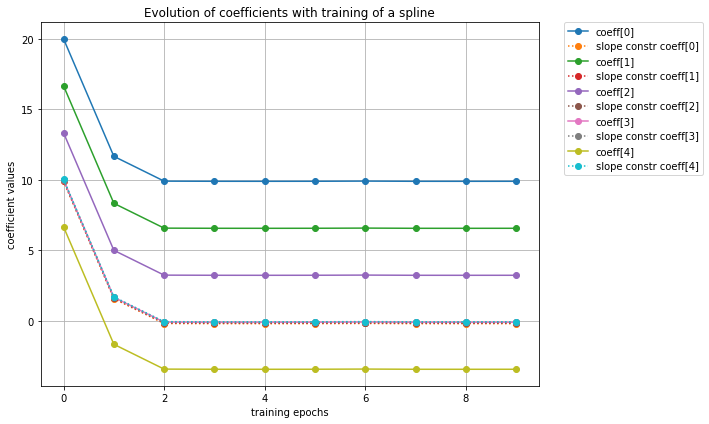

In [117]:
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol2), 
                        np.array(coeffs_const_evol2), log_scale=0)

In [120]:
model2.nodal_val_loc_tensor

tensor([[-20.0000, -16.6667, -13.3333, -10.0000,  -6.6667,  -3.3333,   0.0000]])

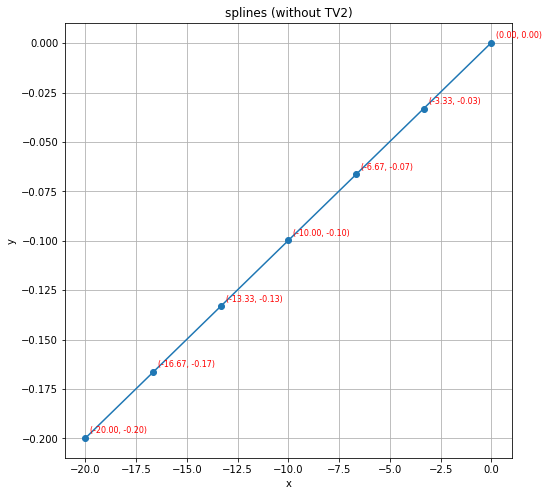

In [121]:
x2,y2= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
plt.figure(figsize=(8,8))
plot_with_annotations(x2[0], y2,
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

### Observation
1. for negative nodal points, learned fn values X10^{-2} off from the correct values 
2. For all +ve nodal points:
    2.1 If i keep range to be 6, SIZE=7 and these nodal values:0.1,1.7,2.7,3.4,4.3,5.1,5.8
    then my slope learned was ~2.
    
    2.2 If i keep range to be 6, SIZE=5 and nodal vals: 0.1,1.7,3.4,4.7,5.8
        ITS A BIT COMPLICATED
    
    2.3 Interesting thing I noted:
        -0.1,0.12,0.7,1.6,3.0 (range 10, but whatever, size=5)
        when i changed 0.7->1.4,0.15, the performance worsened.
       
        (THIS IS EXACTLY WHAT THE AUTHORS ALSO MENTIONED IN THEIR WORK THAT 
        FINDING THE APPROPRIATE POSITION OF NODAL VALUES IS A DIFFICULT 
        TASK. IN THEIR WORK, THEY TRIED TO OVERCOME IT USING TV-2 REGULARISATION)